Datasets used: 
- `adult (Adult)` :<br>The UCI Adult dataset contains 14 features, which can be divided into two categories: demographic and income-related.<br> The demographic features include:

    age: continuous.<br>
    fnlwgt : continuous, represents final weight, which is the number of units in the target population that the responding unit represents.<br>
    workclass: categorical, with values 'Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov', 'State-gov', 'Self-emp-inc', 'Without-pay'.<br>
    education: categorical, with values '11th', 'HS-grad', 'Assoc-acdm', 'Some-college', '10th', ..., '9th', 'Doctorate', '12th', '1st-4th', 'Preschool'.<br>
    education-num: continuous with values 1 to 16, one number assigned to each label of education feature.<br>
    marital-status: categorical, with values 'Never-married', 'Married-civ-spouse', 'Widowed', 'Separated', 'Divorced', 'Married-spouse-absent', 'Married-AF-spouse'.<br>
    occupation: categorical, with values such as 'Machine-op-inspct', 'Farming-fishing', 'Protective-serv'.<br>
    relationship: categorical, with values 'Own-child', 'Husband', 'Not-in-family', 'Unmarried', 'Wife', 'Other-relative'.<br>
    race: categorical, with values such as white, black, and Asian.<br>
    sex: categorical, with values male and female.<br>
    
    The income-related features include:<br>

    hours-per-week: continuous.<br>
    native-country: categorical, with values such as United-States, Mexico, and Germany.<br>
    capital-gain: continuous, represent the amount of money an individual has gained from the sale of investments such as stocks, bonds, or real estate.<br>
    capital-loss: continuous, represent the amount of money an individual has lost from the sale of investments such as stocks, bonds, or real estate..<br>
    The target feature is the income, which is binary:<br>
    income: categorical, with values less than or equal to 50K and greater than 50K.<br>

Reference Links: https://archive.ics.uci.edu/ml/datasets/adult

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..', '..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import facts
from facts.clean import clean_dataset
from facts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from facts.models import customLogisticRegression
from facts.parameters import ParameterProxy
from facts.formatting import recourse_report_reverse, print_recourse_report, print_recourse_report_cumulative, print_recourse_report_KStest_cumulative
from facts.utils import load_rules_by_if, save_rules_by_if
import matplotlib.pyplot as plt

from IPython.display import Markdown, display

In [2]:
random_state = 131313 # change to something for exactly reproducible results  <-------- VERY IMPORTANT

positive_label = 1
negative_label = 0

model_train_fraction = 0.7

## Load Dataset

In [3]:
urlfile= "https://raw.githubusercontent.com/columbia/fairtest/master/data/adult/adult.csv"

X = pd.read_csv(urlfile)
df = clean_dataset(X, "adult")

age = [val.left for val in df.age.unique()]
age.sort()

df.head()

,age,Workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,"(34.0, 41.0]",State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,FullTime,United-States,0
1,"(41.0, 50.0]",Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Married,White,Male,0,0,PartTime,United-States,0
2,"(34.0, 41.0]",Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,FullTime,United-States,0
3,"(50.0, 90.0]",Private,7,Married-civ-spouse,Handlers-cleaners,Married,Black,Male,0,0,FullTime,United-States,0
4,"(26.0, 34.0]",Private,13,Married-civ-spouse,Prof-specialty,Married,Black,Female,0,0,FullTime,Cuba,0


## Model training and test

In [4]:
y = df['income']
X = df.drop('income', axis=1)

num_features = X._get_numeric_data().columns.to_list()
cate_features = X.select_dtypes(include=['object','category']).columns.to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=random_state, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [5]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='income')
model.predict(X_test.iloc[:100, :])

Wall time: 4.02 s


array([0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.])

In [6]:
positive_label = 1
negative_label = 0
preds_Xtest = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds_Xtest))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90     10205
           1       0.73      0.61      0.66      3362

    accuracy                           0.85     13567
   macro avg       0.80      0.77      0.78     13567
weighted avg       0.84      0.85      0.84     13567



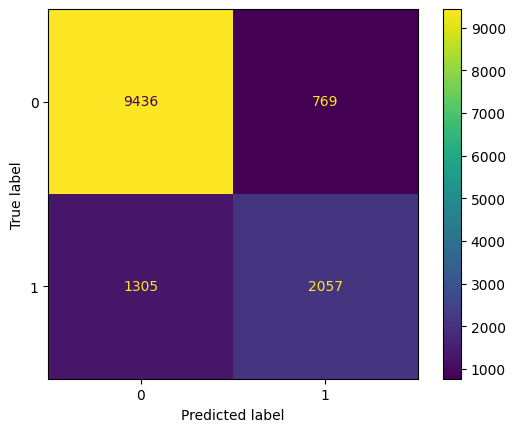

In [7]:
conf_matrix = confusion_matrix(y_test, preds_Xtest)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

In [8]:
def make_binary(val):
    if val in [" Amer-Indian-Eskimo", " Asian-Pac-Islander", " Black", " Other"]:
        return " Non-White"
    elif val == " White":
        return val
    else:
        raise NotImplementedError("Code should be unreachable")

X_test.race = X_test.race.map(make_binary)

## Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [9]:
# ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
#     X_test,
#     model=model,
#     sensitive_attribute='race',
#     freqitem_minsupp=0.01,
#     missing_subgroup_val="Unknown",
#     drop_infeasible=True,
#     drop_above=True
# )

# print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
# rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

In [10]:
### Uncomment if you wish to load state (model, X_test, rules) from disk

import dill

with open("rules-Xtest-model-2_race (seed 131313).data", "rb") as inf:
    (rules_by_if, X_test, model) = dill.load(inf)

In [11]:
# ### Uncomment if you wish to save state (model, X_test, rules) on disk

# import dill

# with open("rules-Xtest-model-2_race (seed 131313).data", "wb") as outf:
#     dill.dump((rules_by_if, X_test, model), outf)

In [12]:
# rules = {}
# features = ['capital-gain','capital-loss']
# for rule in rules_by_if.keys():
#     if all(f not in features for f in rule.features):
#         rules[rule] = rules_by_if[rule]

In [13]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1][" White"][1][0][1]-e[1][" Non-White"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If Workclass =  Private, capital-loss = 0, education-num = 9, hours-per-week = FullTime, occupation =  Craft-repair, relationship =  Married, sex =  Male:
	Protected Subgroup ' Non-White', 1.38% covered
		Make education-num = 10, hours-per-week = OverTime, occupation =  Sales with correctness 16.67%.
		Make education-num = 10, hours-per-week = OverTime, occupation =  Exec-managerial with correctness 58.33%.
		Make education-num = 10, occupation =  Exec-managerial with correctness 29.17%.
	Protected Subgroup ' White', 2.11% covered
		Make education-num = 10, hours-per-week = OverTime, occupation =  Sales with correctness 67.89%.
		Make education-num = 10, hours-per-week = OverTime, occupation =  Exec-managerial with correctness 68.42%.
		Make education-num = 10, occupation =  Exec-managerial with correctness 67.89%.
If Workclass =  Private, capital-loss = 0, education-num = 9, hours-per-week = FullTime, marital-status =  Married-civ-spouse, occupation =  Craft-repair, relationship =  Ma

# Filter rules by different fairness definitions

Here, we explore more sophisticated ways of picking the "top" K rules and showing only those.

We start ranking the rule "groups" (all recourses for a single "if") by averaging out the costs of all suggested recourses, weighted by the respective correctness. For now, the "cost" of a recourse is simply the number of features whose value changes (and the magnitude of the change for numerical features, but here there are none).

In [14]:
num_features = ['education-num', 'capital-gain', 'capital-loss']
cate_features = ['age', 'Workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
ord_features = ['hours-per-week']

feature_weights = {"sex": 1, "age": 1, "relationship": 10, "education-num": 20}
features_with_binary_cost = cate_features
features_with_proportional_cost = num_features


comparators = facts.feature_change_builder(
    X_test,
    num_cols=features_with_proportional_cost,
    cate_cols=features_with_binary_cost,
    ord_cols=ord_features,
    feature_weights=feature_weights,
    num_normalization=True,
    feats_to_normalize = ["capital-gain","capital-loss"]
)
params = ParameterProxy(featureChanges=comparators)

## Weighted Average Score

100%|██████████| 9/9 [00:02<00:00,  4.38it/s]


If capital-gain = 0, native-country =  United-States:
	Protected Subgroup ' Non-White', 76.82% covered out of 1763
		Make capital-gain = 15024 with effectiveness 74.46%.
		Make capital-gain = 7688 with effectiveness 29.87%.
		Make capital-gain = 7298 with effectiveness 27.71%.
		Make capital-gain = 99999 with effectiveness 100.00%.
		Make capital-gain = 5178 with effectiveness 17.77%.
		Make capital-gain = 3103 with effectiveness 9.19%.
		Make capital-gain = 4386 with effectiveness 12.99%.
		Aggregate cost of the above recourses = -3.28
	Protected Subgroup ' White', 89.37% covered out of 8978
		Make capital-gain = 15024 with effectiveness 81.06%.
		Make capital-gain = 7688 with effectiveness 46.64%.
		Make capital-gain = 7298 with effectiveness 44.56%.
		Make capital-gain = 99999 with effectiveness 100.00%.
		Make capital-gain = 5178 with effectiveness 32.66%.
		Make capital-gain = 3103 with effectiveness 20.20%.
		Make capital-gain = 4386 with effectiveness 28.05%.
		Aggregate cost of

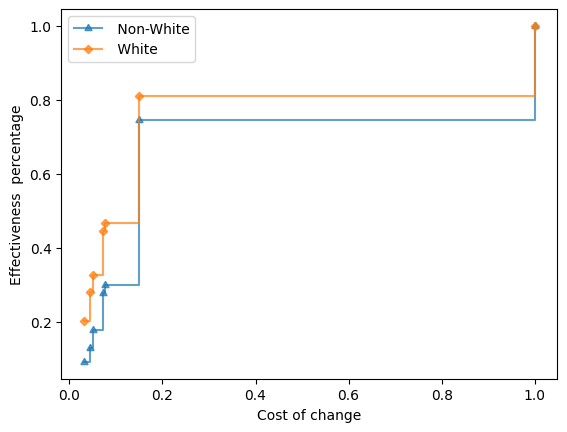

If age = (50.0, 90.0], capital-gain = 0, capital-loss = 0:
	Protected Subgroup ' Non-White', 14.23% covered out of 1763
		Make capital-gain = 15024 with effectiveness 85.89%.
		Make capital-gain = 7688 with effectiveness 38.71%.
		Aggregate cost of the above recourses = -5.38
	Protected Subgroup ' White', 16.63% covered out of 8978
		Make capital-gain = 15024 with effectiveness 96.26%.
		Make capital-gain = 7688 with effectiveness 63.58%.
		Aggregate cost of the above recourses = -7.34
	Bias against  Non-White due to Equal Effectiveness. Unfairness score = 1.96.
	Cumulative effectiveness plot for the above recourses:


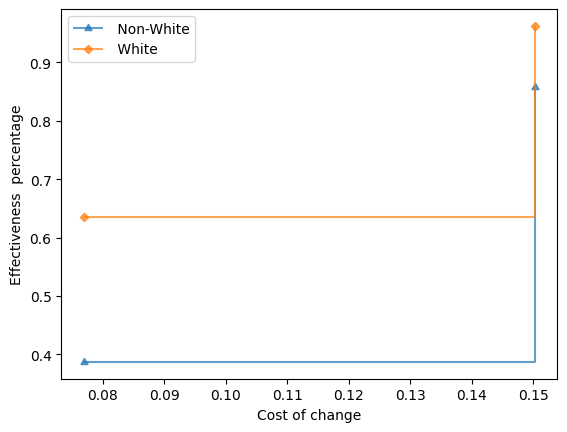

If capital-gain = 0, capital-loss = 0, marital-status =  Married-civ-spouse, native-country =  United-States:
	Protected Subgroup ' Non-White', 17.96% covered out of 1763
		Make capital-gain = 15024 with effectiveness 99.68%.
		Make capital-gain = 7688 with effectiveness 84.35%.
		Make capital-gain = 7298 with effectiveness 81.15%.
		Make capital-loss = 1902 with effectiveness 40.26%.
		Make capital-loss = 1977 with effectiveness 40.89%.
		Make capital-loss = 1887 with effectiveness 40.26%.
		Make capital-gain = 99999 with effectiveness 100.00%.
		Make capital-gain = 5178 with effectiveness 59.42%.
		Make capital-gain = 3103 with effectiveness 34.19%.
		Make capital-gain = 4386 with effectiveness 46.96%.
		Aggregate cost of the above recourses = -6.57
	Protected Subgroup ' White', 31.19% covered out of 8978
		Make capital-gain = 15024 with effectiveness 99.86%.
		Make capital-gain = 7688 with effectiveness 91.25%.
		Make capital-gain = 7298 with effectiveness 89.58%.
		Make capital-los

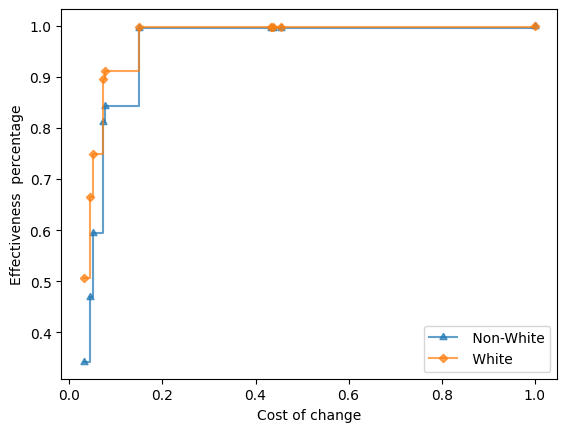

If capital-gain = 0, education-num = 13:
	Protected Subgroup ' Non-White', 9.87% covered out of 1763
		Make education-num = 14 with effectiveness 4.65%.
		Make education-num = 15 with effectiveness 6.98%.
		Make capital-gain = 15024 with effectiveness 95.35%.
		Make capital-gain = 7688 with effectiveness 47.67%.
		Make capital-gain = 7298 with effectiveness 45.35%.
		Aggregate cost of the above recourses = -3.75
	Protected Subgroup ' White', 10.74% covered out of 8978
		Make education-num = 14 with effectiveness 5.68%.
		Make education-num = 15 with effectiveness 11.05%.
		Make capital-gain = 15024 with effectiveness 97.93%.
		Make capital-gain = 7688 with effectiveness 60.95%.
		Make capital-gain = 7298 with effectiveness 58.68%.
		Aggregate cost of the above recourses = -4.50
	Bias against  Non-White due to Equal Effectiveness. Unfairness score = 0.75.
	Cumulative effectiveness plot for the above recourses:


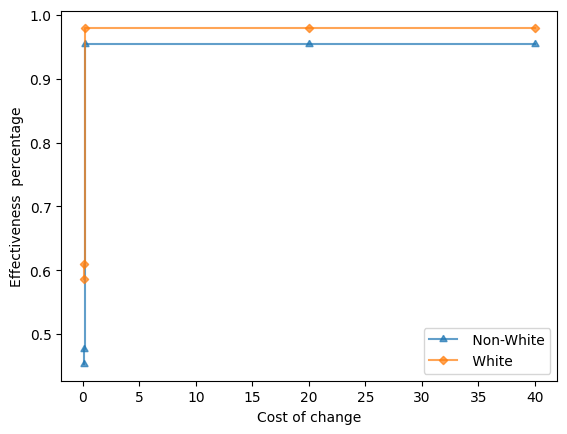

If age = (41.0, 50.0], capital-gain = 0, native-country =  United-States:
	Protected Subgroup ' Non-White', 12.62% covered out of 1763
		Make age = (50.0, 90.0] with effectiveness 0.00%.
		Make capital-gain = 15024 with effectiveness 96.82%.
		Make capital-gain = 7688 with effectiveness 49.09%.
		Make age = (50.0, 90.0], capital-gain = 15024 with effectiveness 95.45%.
		Aggregate cost of the above recourses = -3.41
	Protected Subgroup ' White', 14.21% covered out of 8978
		Make age = (50.0, 90.0] with effectiveness 0.00%.
		Make capital-gain = 15024 with effectiveness 98.59%.
		Make capital-gain = 7688 with effectiveness 69.63%.
		Make age = (50.0, 90.0], capital-gain = 15024 with effectiveness 97.89%.
		Aggregate cost of the above recourses = -4.12
	Bias against  Non-White due to Equal Effectiveness. Unfairness score = 0.7.
	Cumulative effectiveness plot for the above recourses:


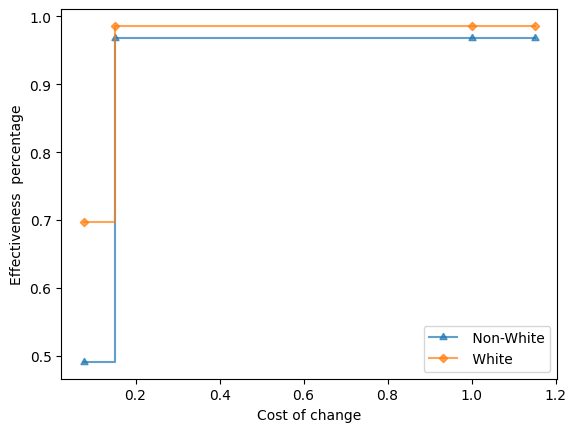

If capital-gain = 0, capital-loss = 0, education-num = 13:
	Protected Subgroup ' Non-White', 9.70% covered out of 1763
		Make education-num = 14 with effectiveness 4.73%.
		Make education-num = 15 with effectiveness 7.10%.
		Make capital-gain = 15024 with effectiveness 95.27%.
		Make capital-gain = 7688 with effectiveness 46.75%.
		Make capital-gain = 7298 with effectiveness 44.38%.
		Make capital-loss = 1902 with effectiveness 13.61%.
		Aggregate cost of the above recourses = -3.14
	Protected Subgroup ' White', 10.35% covered out of 8978
		Make education-num = 14 with effectiveness 5.57%.
		Make education-num = 15 with effectiveness 10.93%.
		Make capital-gain = 15024 with effectiveness 97.86%.
		Make capital-gain = 7688 with effectiveness 59.91%.
		Make capital-gain = 7298 with effectiveness 57.88%.
		Make capital-loss = 1902 with effectiveness 23.58%.
		Aggregate cost of the above recourses = -3.80
	Bias against  Non-White due to Equal Effectiveness. Unfairness score = 0.66.
	Cumula

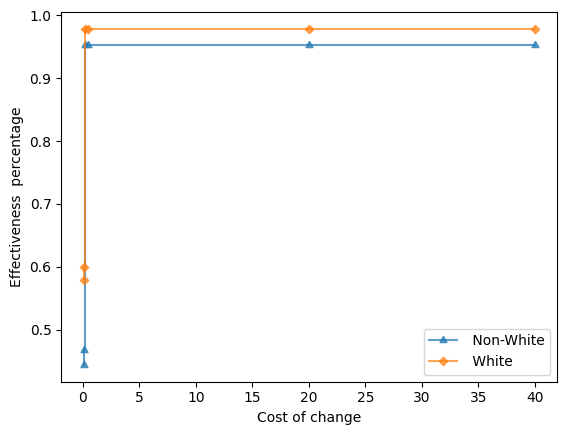

If age = (41.0, 50.0], capital-gain = 0, capital-loss = 0, native-country =  United-States:
	Protected Subgroup ' Non-White', 12.51% covered out of 1763
		Make age = (50.0, 90.0] with effectiveness 0.00%.
		Make capital-gain = 15024 with effectiveness 96.79%.
		Make capital-gain = 7688 with effectiveness 48.62%.
		Make age = (50.0, 90.0], capital-gain = 15024 with effectiveness 95.41%.
		Make capital-loss = 1902 with effectiveness 22.94%.
		Aggregate cost of the above recourses = -2.82
	Protected Subgroup ' White', 13.76% covered out of 8978
		Make age = (50.0, 90.0] with effectiveness 0.00%.
		Make capital-gain = 15024 with effectiveness 98.55%.
		Make capital-gain = 7688 with effectiveness 69.14%.
		Make age = (50.0, 90.0], capital-gain = 15024 with effectiveness 97.82%.
		Make capital-loss = 1902 with effectiveness 40.69%.
		Aggregate cost of the above recourses = -3.47
	Bias against  Non-White due to Equal Effectiveness. Unfairness score = 0.64.
	Cumulative effectiveness plot for t

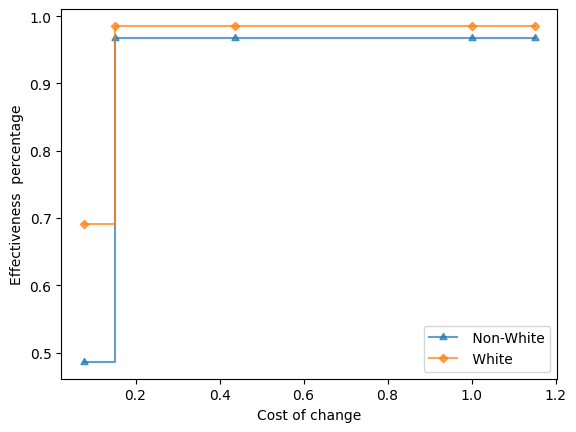

If capital-gain = 0, hours-per-week = OverTime, native-country =  United-States, sex =  Male:
	Protected Subgroup ' Non-White', 5.22% covered out of 1763
		Make hours-per-week = FullTime with effectiveness 0.00%.
		Make hours-per-week = BrainDrain with effectiveness 1.10%.
		Make capital-gain = 15024 with effectiveness 92.31%.
		Make hours-per-week = MidTime with effectiveness 0.00%.
		Make capital-gain = 7688 with effectiveness 49.45%.
		Make capital-gain = 7688, hours-per-week = FullTime with effectiveness 46.15%.
		Make capital-gain = 7298, hours-per-week = FullTime with effectiveness 43.96%.
		Make capital-gain = 15024, hours-per-week = FullTime with effectiveness 86.81%.
		Make capital-gain = 7298 with effectiveness 46.15%.
		Make capital-gain = 15024, hours-per-week = BrainDrain with effectiveness 93.41%.
		Aggregate cost of the above recourses = -2.13
	Protected Subgroup ' White', 12.72% covered out of 8978
		Make hours-per-week = FullTime with effectiveness 0.00%.
		Make hours-

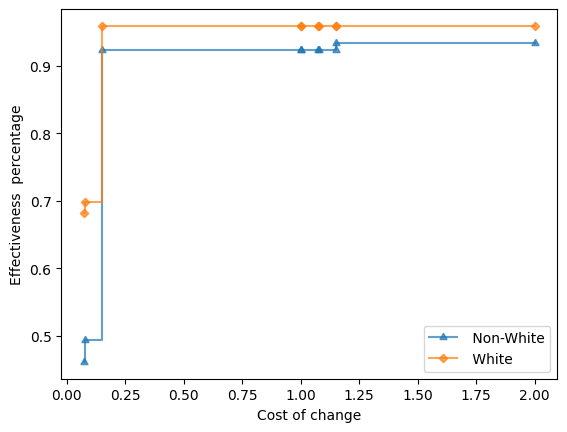

If capital-gain = 0, capital-loss = 0, hours-per-week = OverTime, native-country =  United-States, sex =  Male:
	Protected Subgroup ' Non-White', 4.99% covered out of 1763
		Make hours-per-week = FullTime with effectiveness 0.00%.
		Make hours-per-week = BrainDrain with effectiveness 1.15%.
		Make capital-gain = 15024 with effectiveness 91.95%.
		Make hours-per-week = MidTime with effectiveness 0.00%.
		Make capital-gain = 7688 with effectiveness 49.43%.
		Make capital-gain = 7688, hours-per-week = FullTime with effectiveness 45.98%.
		Make capital-gain = 7298, hours-per-week = FullTime with effectiveness 43.68%.
		Make capital-gain = 15024, hours-per-week = FullTime with effectiveness 86.21%.
		Make capital-gain = 7298 with effectiveness 45.98%.
		Make capital-loss = 1887, hours-per-week = FullTime with effectiveness 19.54%.
		Make capital-gain = 15024, hours-per-week = BrainDrain with effectiveness 93.10%.
		Aggregate cost of the above recourses = -1.94
	Protected Subgroup ' White', 

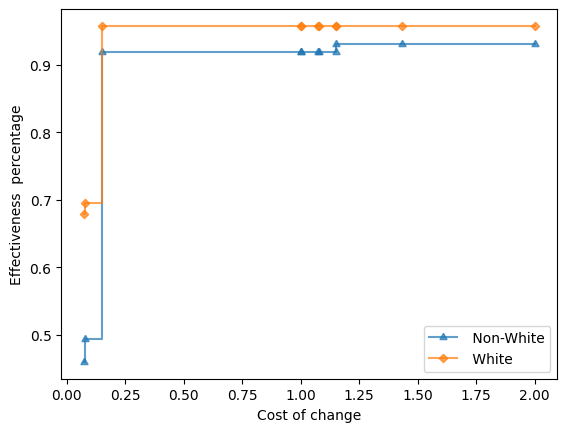

In [15]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric = "weighted-average",
    sort_strategy = "abs-diff-decr",
    top_count = 50,
    filter_sequence = [
        "remove-contained",
        # "remove-fair-rules",
    ],
    cor_threshold=None,
    secondary_sorting_objectives=[
        # "min-group-cost",
        # "max-group-corr"
    ],
    params=params
)

cum_cors = facts.cum_corr_costs_all_minimal(top_rules, X_test, model, sensitive_attribute="race", params=params)

pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}
print_recourse_report(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors,
    show_subgroup_costs=True
)

## Minimum cost above threshold

In [16]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",        
        "remove-fair-rules",
        "keep-only-min-change"
    ],
    cor_threshold=0.5,
    secondary_sorting_objectives=[
        # "min-group-cost",
        "max-group-corr"
    ],
    params=params
)

# cum_cors = facts.cum_corr_costs_all_minimal(top_rules, X_test, model, sensitive_attribute="race", params=params)
cum_cors = dict()

pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}
print_recourse_report(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors,
    show_subgroup_costs=True
)

If education-num = 9, occupation =  Transport-moving, relationship =  Married:
	Protected Subgroup ' Non-White', 1.84% covered out of 1763
		Make education-num = 11, occupation =  Exec-managerial with effectiveness 68.75%.
		Aggregate cost of the above recourses = 41.00
	Protected Subgroup ' White', 1.97% covered out of 8978
		Make occupation =  Exec-managerial with effectiveness 50.00%.
		Aggregate cost of the above recourses = 1.00
	Bias against  Non-White due to Equal Effectiveness. Unfairness score = 40.
If education-num = 9, marital-status =  Married-civ-spouse, native-country =  United-States, occupation =  Transport-moving:
	Protected Subgroup ' Non-White', 1.55% covered out of 1763
		Make education-num = 11, occupation =  Exec-managerial with effectiveness 70.37%.
		Aggregate cost of the above recourses = 41.00
	Protected Subgroup ' White', 1.94% covered out of 8978
		Make occupation =  Exec-managerial with effectiveness 50.29%.
		Aggregate cost of the above recourses = 1.00
	B

## Mean cost above threshold

In [17]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="mean-above-thr",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",
        "remove-fair-rules",
        # "keep-only-min-change"
    ],
    cor_threshold=0.2,
    secondary_sorting_objectives=[
        # "min-group-cost",
        # "max-group-corr"
    ],
    params=params
)

# cum_cors = facts.cum_corr_costs_all_minimal(top_rules, X_test, model, sensitive_attribute="race", params=params)
cum_cors = dict()

pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}
print_recourse_report(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors,
    show_subgroup_costs=True
)

If capital-loss = 0:
	Protected Subgroup ' Non-White', 97.59% covered out of 1763
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Protected Subgroup ' White', 97.15% covered out of 8978
		Make capital-loss = 1902 with effectiveness 22.83%.
		Make capital-loss = 1977 with effectiveness 23.60%.
		Make capital-loss = 1887 with effectiveness 22.77%.
		Aggregate cost of the above recourses = 0.44
	Bias against  Non-White due to Equal Effectiveness. Unfairness score = inf.
If Workclass =  Private, capital-loss = 0:
	Protected Subgroup ' Non-White', 74.99% covered out of 1763
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Protected Subgroup ' White', 75.27% covered out of 8978
		Make capital-loss = 1902 with effectiveness 20.31%.
		Make capital-loss = 1887 with effectiveness 20.26%.
		Make capital-loss = 1977 with effectiveness 20.95%.
		Aggregate cost of the above recourses = 0.44
	Bias against  Non-White due to Equal Effecti

## Number above threshold

In [18]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",
        # "remove-fair-rules"
    ],
    cor_threshold=0.2,
    secondary_sorting_objectives=[
        # "min-group-cost",
        # "max-group-corr"
    ],
    params=params
)

# cum_cors = facts.cum_corr_costs_all_minimal(top_rules, X_test, model, sensitive_attribute="race", params=params)
cum_cors = dict()

pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}
print_recourse_report(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors,
    show_subgroup_costs=True
)

If Workclass =  Private, hours-per-week = PartTime, marital-status =  Married-civ-spouse:
	Protected Subgroup ' Non-White', 1.32% covered out of 1763
		No recourses for this subgroup!
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup ' White', 1.54% covered out of 8978
		Make hours-per-week = OverTime with effectiveness 35.97%.
		Make hours-per-week = FullTime with effectiveness 26.62%.
		Make hours-per-week = BrainDrain with effectiveness 38.13%.
		Make Workclass =  Self-emp-inc, hours-per-week = OverTime with effectiveness 44.60%.
		Make Workclass =  Local-gov, hours-per-week = FullTime with effectiveness 25.18%.
		Make Workclass =  Federal-gov, hours-per-week = FullTime with effectiveness 38.13%.
		Make Workclass =  Self-emp-not-inc, hours-per-week = OverTime with effectiveness 20.86%.
		Make Workclass =  Self-emp-inc, hours-per-week = BrainDrain with effectiveness 45.32%.
		Make Workclass =  Local-gov, hours-per-week = OverTime with effectiveness 33.81%.
		Make Wor

# Micro viewpoint

In [20]:
# rules_with_cumulative = facts.cum_corr_costs_all(rules_by_if, X_test, model, sensitive_attribute="race", params=params)

In [30]:
## Use this for loading rules from disk
# rules_with_cumulative = load_rules_by_if(f"rulesAdultFairTest_race_cumulative (seed {random_state}).data")

## Use this for saving rules on disk
# save_rules_by_if(f"rulesAdultFairTest_race_cumulative (seed {random_state}).data", rules_with_cumulative)

In [24]:
with open("rulesAdultFairTest_race_cumulative (seed 131313).data", "rb") as inf:
    (rules_with_cumulative) = dill.load(inf)

# Fairness of Mean Recourse ($c_\infty$ implementation)

If education-num = 14, relationship =  Not-in-family:
	Protected Subgroup ' Non-White', 1.20% covered out of 1763
		Make relationship =  Married with effectiveness 4.76% and counterfactual cost = 10.0.
		Make education-num = 15, relationship =  Married with effectiveness 9.52% and counterfactual cost = 30.0.
		Make education-num = 16, relationship =  Married with effectiveness 9.52% and counterfactual cost = 50.0.
		Aggregate cost of the above recourses = 109.96
	Protected Subgroup ' White', 2.02% covered out of 8978
		Make relationship =  Married with effectiveness 21.98% and counterfactual cost = 10.0.
		Make education-num = 15, relationship =  Married with effectiveness 36.81% and counterfactual cost = 30.0.
		Make education-num = 16, relationship =  Married with effectiveness 52.75% and counterfactual cost = 50.0.
		Aggregate cost of the above recourses = 14.62
	Bias against  Non-White due to Equal Effectiveness. Unfairness score = 95.348.
	Cumulative effectiveness plot for the abo

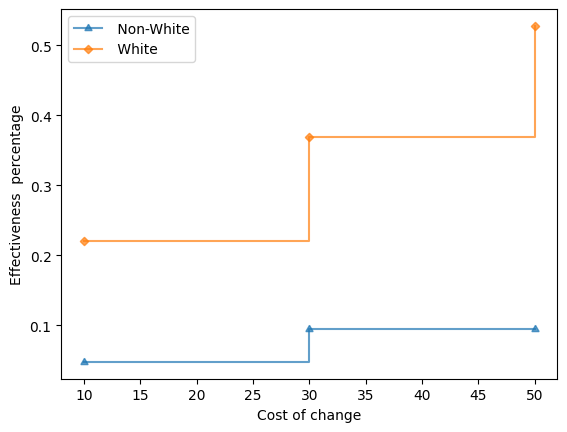

If age = (26.0, 34.0], education-num = 10, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Non-White', 1.43% covered out of 1763
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 16.00% and counterfactual cost = 12.0.
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 24.00% and counterfactual cost = 12.0.
		Make age = (34.0, 41.0], education-num = 11, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 28.00% and counterfactual cost = 32.0.
		Make age = (41.0, 50.0], education-num = 11, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 32.00% and counterfactual cost = 32.0.
		Make age = (41.0, 50.0], education-num = 12, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 36.00% and counterfactual cost = 52.0.
		Make age = (34.0, 41.0], education-n

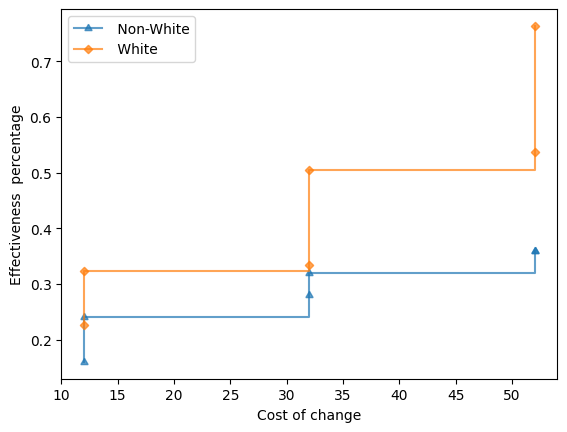

If Workclass =  Private, capital-gain = 0, education-num = 9, marital-status =  Divorced, relationship =  Not-in-family:
	Protected Subgroup ' Non-White', 1.38% covered out of 1763
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 0.00% and counterfactual cost = 11.0.
		Make Workclass =  Self-emp-inc, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 0.00% and counterfactual cost = 12.0.
		Make education-num = 10, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 0.00% and counterfactual cost = 31.0.
		Make Workclass =  Self-emp-inc, education-num = 10, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 0.00% and counterfactual cost = 32.0.
		Make Workclass =  Federal-gov, education-num = 10, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 0.00% and counterfactual cost = 32.0.
		Make education-num = 11, marital-status =  Marr

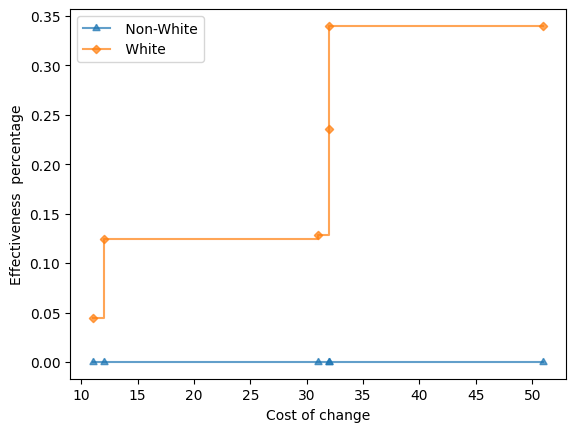

If capital-loss = 0, education-num = 13, relationship =  Unmarried:
	Protected Subgroup ' Non-White', 2.58% covered out of 1763
		Make relationship =  Not-in-family with effectiveness 2.22% and counterfactual cost = 10.0.
		Make relationship =  Married with effectiveness 8.89% and counterfactual cost = 10.0.
		Make capital-loss = 1902, relationship =  Married with effectiveness 51.11% and counterfactual cost = 10.44.
		Make education-num = 14, relationship =  Married with effectiveness 51.11% and counterfactual cost = 30.0.
		Make education-num = 15, relationship =  Married with effectiveness 51.11% and counterfactual cost = 50.0.
		Aggregate cost of the above recourses = 80.15
	Protected Subgroup ' White', 1.05% covered out of 8978
		Make relationship =  Not-in-family with effectiveness 3.16% and counterfactual cost = 10.0.
		Make relationship =  Married with effectiveness 18.95% and counterfactual cost = 10.0.
		Make capital-loss = 1902, relationship =  Married with effectiveness 81.

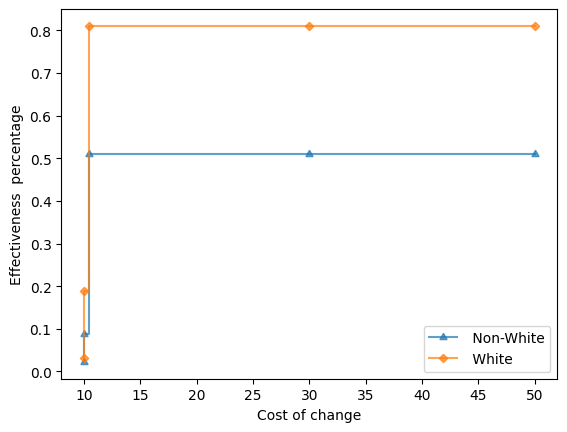

If education-num = 9, hours-per-week = FullTime, marital-status =  Divorced, relationship =  Not-in-family:
	Protected Subgroup ' Non-White', 1.09% covered out of 1763
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 0.00% and counterfactual cost = 11.0.
		Make hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 0.00% and counterfactual cost = 12.0.
		Make hours-per-week = BrainDrain, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 0.00% and counterfactual cost = 13.0.
		Make education-num = 10, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 0.00% and counterfactual cost = 31.0.
		Make education-num = 10, hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 5.26% and counterfactual cost = 32.0.
		Make education-num = 10, hours-per-week = BrainDrain, marital-status =  Marri

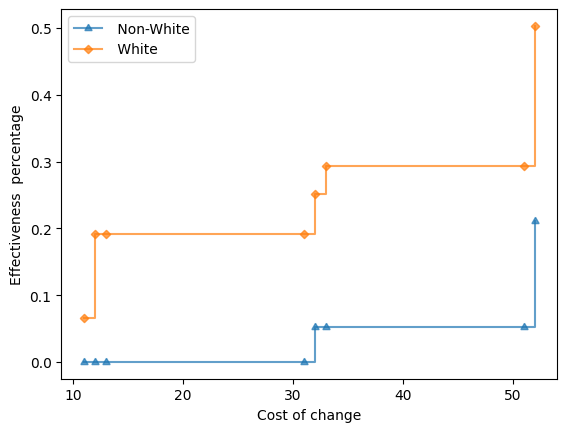

If age = (34.0, 41.0], education-num = 9, relationship =  Married, sex =  Male:
	Protected Subgroup ' Non-White', 1.72% covered out of 1763
		Make age = (41.0, 50.0] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make age = (50.0, 90.0] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make education-num = 10 with effectiveness 0.00% and counterfactual cost = 20.0.
		Make age = (50.0, 90.0], education-num = 10 with effectiveness 0.00% and counterfactual cost = 21.0.
		Make age = (41.0, 50.0], education-num = 10 with effectiveness 3.33% and counterfactual cost = 21.0.
		Make age = (41.0, 50.0], education-num = 11 with effectiveness 6.67% and counterfactual cost = 41.0.
		Aggregate cost of the above recourses = 81.17
	Protected Subgroup ' White', 3.04% covered out of 8978
		Make age = (50.0, 90.0] with effectiveness 1.09% and counterfactual cost = 1.0.
		Make age = (41.0, 50.0] with effectiveness 8.03% and counterfactual cost = 1.0.
		Make education-num = 10 with effec

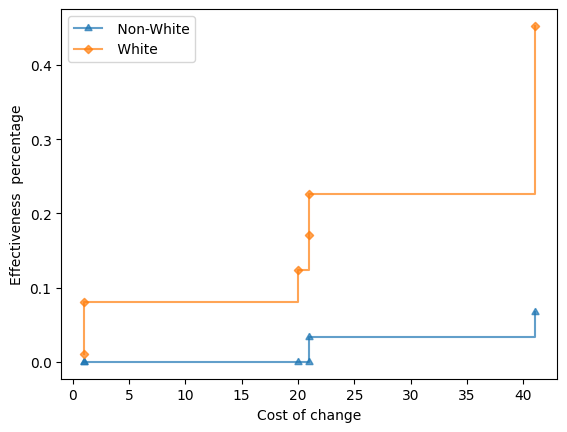

If Workclass =  Private, capital-gain = 0, education-num = 9, marital-status =  Divorced, relationship =  Unmarried:
	Protected Subgroup ' Non-White', 1.49% covered out of 1763
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 0.00% and counterfactual cost = 11.0.
		Make Workclass =  Self-emp-inc, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 0.00% and counterfactual cost = 12.0.
		Make education-num = 10, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 0.00% and counterfactual cost = 31.0.
		Make Workclass =  Self-emp-inc, education-num = 10, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 3.85% and counterfactual cost = 32.0.
		Make Workclass =  Federal-gov, education-num = 10, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 7.69% and counterfactual cost = 32.0.
		Make education-num = 11, marital-status =  Married-

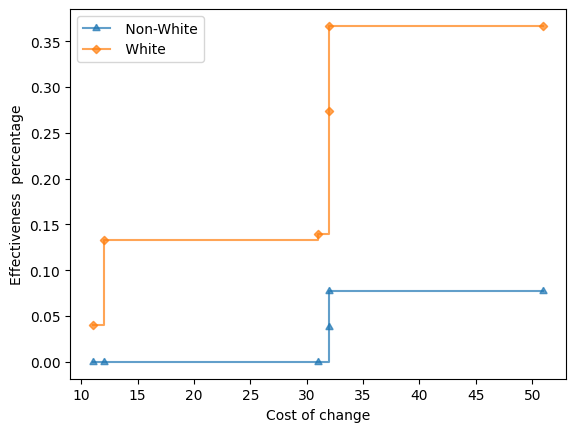

In [25]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="fairness-of-mean-recourse-cinf",
    c_inf=5,
    sort_strategy="generic-sorting",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        # "remove-fair-rules"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric=False
)

# Fairness of Mean Recourse ("conditional expectation" implementation)

If Workclass =  Private, capital-loss = 0, education-num = 10, hours-per-week = FullTime, marital-status =  Never-married, sex =  Male:
	Protected Subgroup ' Non-White', 2.35% covered out of 1763
		Make marital-status =  Married-civ-spouse with effectiveness 2.44% and counterfactual cost = 1.0.
		Make hours-per-week = OverTime, marital-status =  Married-civ-spouse with effectiveness 2.44% and counterfactual cost = 2.0.
		Make hours-per-week = BrainDrain, marital-status =  Married-civ-spouse with effectiveness 2.44% and counterfactual cost = 3.0.
		Make education-num = 11, marital-status =  Married-civ-spouse with effectiveness 2.44% and counterfactual cost = 21.0.
		Make education-num = 11, hours-per-week = OverTime, marital-status =  Married-civ-spouse with effectiveness 2.44% and counterfactual cost = 22.0.
		Make education-num = 12, hours-per-week = OverTime, marital-status =  Married-civ-spouse with effectiveness 2.44% and counterfactual cost = 42.0.
		Aggregate cost of the above r

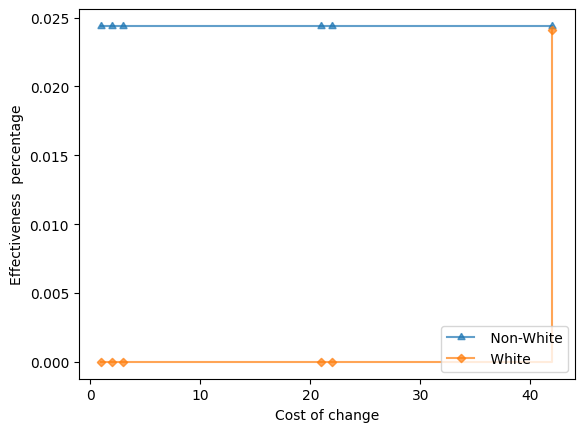

If Workclass =  Private, capital-loss = 0, education-num = 10, hours-per-week = FullTime, native-country =  United-States, relationship =  Not-in-family, sex =  Male:
	Protected Subgroup ' Non-White', 1.20% covered out of 1763
		Make relationship =  Married with effectiveness 0.00% and counterfactual cost = 10.0.
		Make hours-per-week = OverTime, relationship =  Married with effectiveness 4.76% and counterfactual cost = 11.0.
		Make hours-per-week = BrainDrain, relationship =  Married with effectiveness 4.76% and counterfactual cost = 12.0.
		Make education-num = 12, hours-per-week = OverTime, relationship =  Married with effectiveness 4.76% and counterfactual cost = 51.0.
		Aggregate cost of the above recourses = 11.00
	Protected Subgroup ' White', 1.10% covered out of 8978
		Make relationship =  Married with effectiveness 0.00% and counterfactual cost = 10.0.
		Make hours-per-week = OverTime, relationship =  Married with effectiveness 0.00% and counterfactual cost = 11.0.
		Make hour

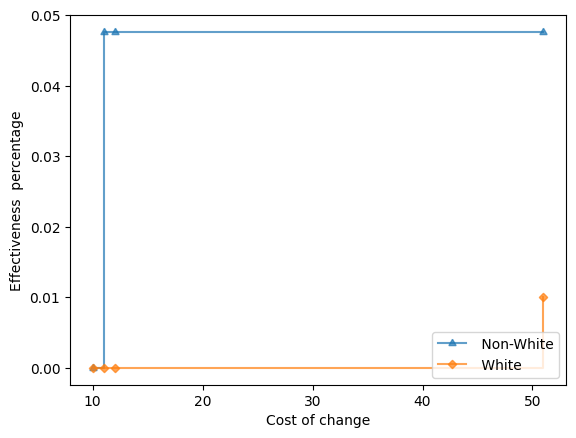

If education-num = 9, hours-per-week = FullTime, relationship =  Unmarried:
	Protected Subgroup ' Non-White', 5.28% covered out of 1763
		Make relationship =  Married with effectiveness 0.00% and counterfactual cost = 10.0.
		Make hours-per-week = OverTime, relationship =  Married with effectiveness 1.09% and counterfactual cost = 11.0.
		Make hours-per-week = BrainDrain, relationship =  Married with effectiveness 1.09% and counterfactual cost = 12.0.
		Make education-num = 10, relationship =  Married with effectiveness 1.09% and counterfactual cost = 30.0.
		Make education-num = 10, hours-per-week = OverTime, relationship =  Married with effectiveness 1.09% and counterfactual cost = 31.0.
		Make education-num = 10, hours-per-week = BrainDrain, relationship =  Married with effectiveness 1.09% and counterfactual cost = 32.0.
		Make education-num = 11, relationship =  Married with effectiveness 1.09% and counterfactual cost = 50.0.
		Make education-num = 11, hours-per-week = OverTime, re

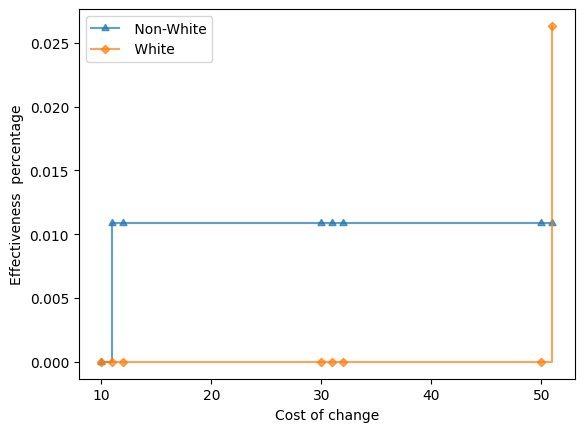

If capital-loss = 0, education-num = 10, relationship =  Unmarried:
	Protected Subgroup ' Non-White', 5.22% covered out of 1763
		Make relationship =  Married with effectiveness 0.00% and counterfactual cost = 10.0.
		Make education-num = 11, relationship =  Married with effectiveness 0.00% and counterfactual cost = 30.0.
		Make education-num = 12, relationship =  Married with effectiveness 2.20% and counterfactual cost = 50.0.
		Aggregate cost of the above recourses = 50.00
	Protected Subgroup ' White', 2.50% covered out of 8978
		Make relationship =  Married with effectiveness 2.67% and counterfactual cost = 10.0.
		Make education-num = 11, relationship =  Married with effectiveness 2.67% and counterfactual cost = 30.0.
		Make education-num = 12, relationship =  Married with effectiveness 2.67% and counterfactual cost = 50.0.
		Aggregate cost of the above recourses = 10.00
	Bias against  Non-White due to Equal Effectiveness. Unfairness score = 40.0.
	Cumulative effectiveness plot for

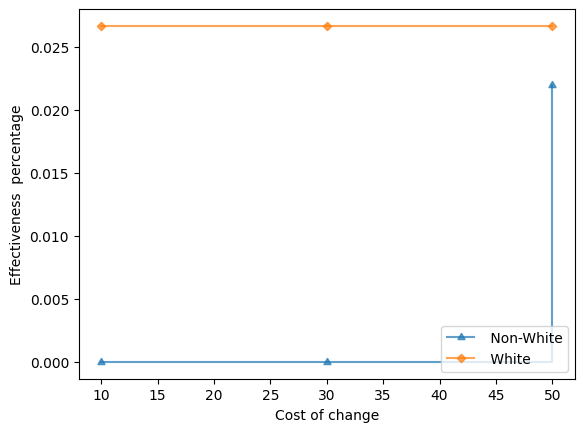

In [26]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="fairness-of-mean-recourse-conditional",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=10,
    filter_sequence = [
        "remove-contained",
        # "remove-fair-rules"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric=False
)

## Fairness of Coverage

If age = (34.0, 41.0], capital-loss = 0, native-country =  United-States, occupation =  Machine-op-inspct:
	Protected Subgroup ' Non-White', 1.38% covered out of 1763
		Make occupation =  Exec-managerial with effectiveness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with effectiveness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Sales with effectiveness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Adm-clerical with effectiveness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Tech-support with effectiveness 0.00% and counterfactual cost = 1.0.
		Make age = (41.0, 50.0], occupation =  Exec-managerial with effectiveness 0.00% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Prof-specialty with effectiveness 0.00% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =  Exec-managerial with effectiv

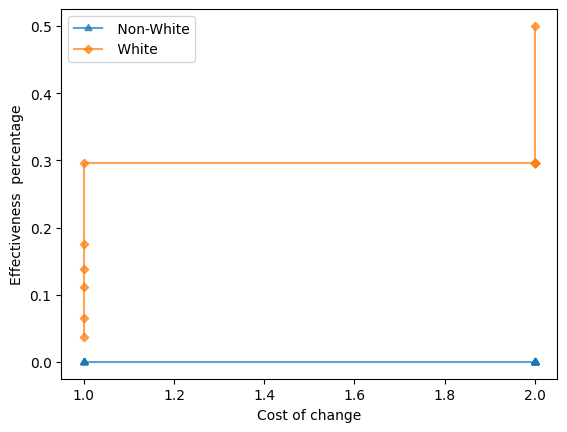

If education-num = 14, relationship =  Not-in-family:
	Protected Subgroup ' Non-White', 1.20% covered out of 1763
		Make relationship =  Married with effectiveness 4.76% and counterfactual cost = 10.0.
		Make education-num = 15, relationship =  Married with effectiveness 9.52% and counterfactual cost = 30.0.
		Make education-num = 16, relationship =  Married with effectiveness 9.52% and counterfactual cost = 50.0.
		Aggregate cost of the above recourses = 0.10
	Protected Subgroup ' White', 2.02% covered out of 8978
		Make relationship =  Married with effectiveness 21.98% and counterfactual cost = 10.0.
		Make education-num = 15, relationship =  Married with effectiveness 36.81% and counterfactual cost = 30.0.
		Make education-num = 16, relationship =  Married with effectiveness 52.75% and counterfactual cost = 50.0.
		Aggregate cost of the above recourses = 0.53
	Bias against  Non-White due to Equal Effectiveness. Unfairness score = 0.432.
	Cumulative effectiveness plot for the above r

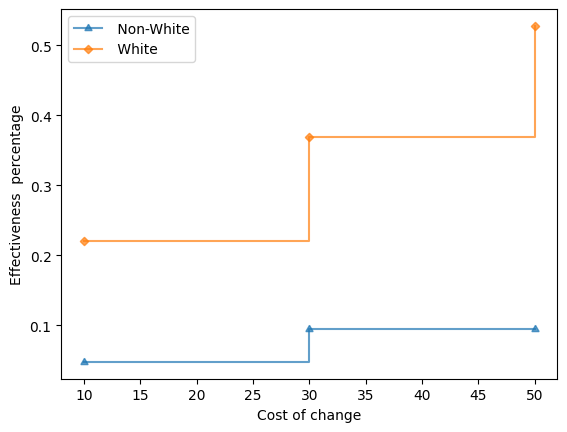

If age = (34.0, 41.0], capital-gain = 0, capital-loss = 0, marital-status =  Married-civ-spouse, occupation =  Craft-repair:
	Protected Subgroup ' Non-White', 1.09% covered out of 1763
		Make occupation =  Sales with effectiveness 0.00% and counterfactual cost = 1.0.
		Make age = (41.0, 50.0] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with effectiveness 5.26% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with effectiveness 10.53% and counterfactual cost = 1.0.
		Make age = (50.0, 90.0], occupation =  Sales with effectiveness 10.53% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Adm-clerical with effectiveness 10.53% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =  Prof-specialty with effectiveness 10.53% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Sales with effectiveness 10.53% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occup

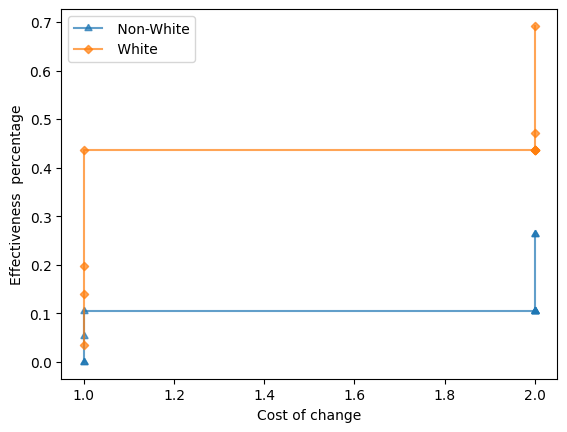

If age = (34.0, 41.0], capital-loss = 0, marital-status =  Never-married, relationship =  Not-in-family, sex =  Male:
	Protected Subgroup ' Non-White', 1.09% covered out of 1763
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 21.05% and counterfactual cost = 11.0.
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 26.32% and counterfactual cost = 12.0.
		Make age = (50.0, 90.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 26.32% and counterfactual cost = 12.0.
		Make age = (41.0, 50.0], capital-loss = 1902, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 42.11% and counterfactual cost = 12.44.
		Aggregate cost of the above recourses = 0.42
	Protected Subgroup ' White', 1.71% covered out of 8978
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 38.96% and counterfactual cost = 11.0.
		

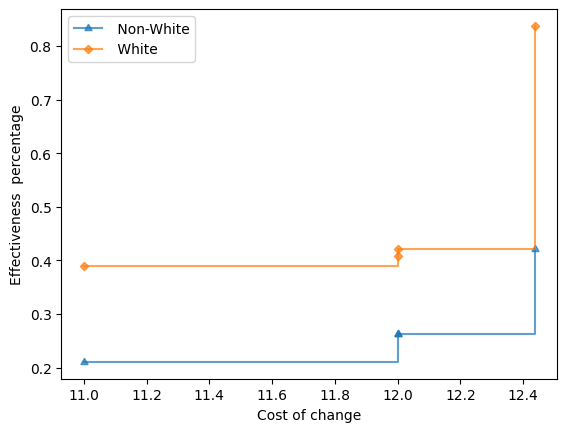

If Workclass =  Self-emp-not-inc, capital-loss = 0, native-country =  United-States, relationship =  Married, sex =  Male:
	Protected Subgroup ' Non-White', 1.09% covered out of 1763
		Make Workclass =  Local-gov with effectiveness 5.26% and counterfactual cost = 1.0.
		Make Workclass =  State-gov with effectiveness 5.26% and counterfactual cost = 1.0.
		Make Workclass =  Private with effectiveness 10.53% and counterfactual cost = 1.0.
		Make Workclass =  Self-emp-inc with effectiveness 26.32% and counterfactual cost = 1.0.
		Make Workclass =  Federal-gov with effectiveness 26.32% and counterfactual cost = 1.0.
		Make Workclass =  Private, capital-loss = 1887 with effectiveness 31.58% and counterfactual cost = 1.43.
		Make Workclass =  Private, capital-loss = 1902 with effectiveness 31.58% and counterfactual cost = 1.44.
		Make Workclass =  Private, capital-loss = 1977 with effectiveness 31.58% and counterfactual cost = 1.45.
		Make Workclass =  Private, relationship =  Not-in-family w

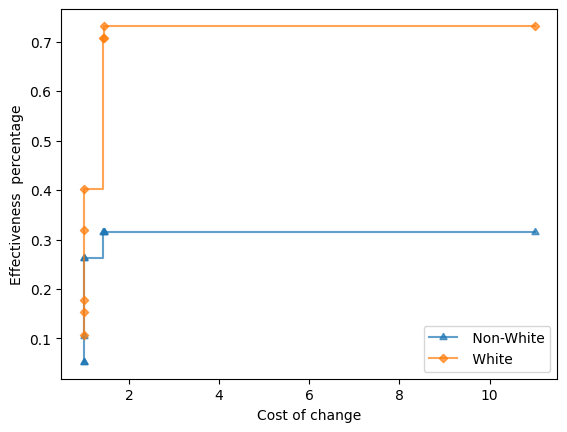

If age = (34.0, 41.0], capital-loss = 0, occupation =  Craft-repair, relationship =  Married:
	Protected Subgroup ' Non-White', 1.03% covered out of 1763
		Make occupation =  Sales with effectiveness 0.00% and counterfactual cost = 1.0.
		Make age = (41.0, 50.0] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Adm-clerical with effectiveness 0.00% and counterfactual cost = 1.0.
		Make age = (50.0, 90.0] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with effectiveness 5.56% and counterfactual cost = 1.0.
		Make occupation =  Tech-support with effectiveness 5.56% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with effectiveness 11.11% and counterfactual cost = 1.0.
		Make age = (50.0, 90.0], occupation =  Sales with effectiveness 11.11% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Adm-clerical with effectiveness 11.11% and counterfactual cost = 2.0.
		Make age = (50.0

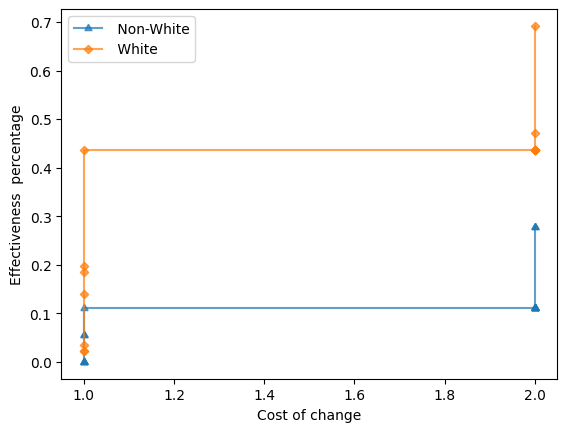

If age = (26.0, 34.0], education-num = 10, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Non-White', 1.43% covered out of 1763
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 16.00% and counterfactual cost = 12.0.
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 24.00% and counterfactual cost = 12.0.
		Make age = (34.0, 41.0], education-num = 11, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 28.00% and counterfactual cost = 32.0.
		Make age = (41.0, 50.0], education-num = 11, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 32.00% and counterfactual cost = 32.0.
		Make age = (41.0, 50.0], education-num = 12, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 36.00% and counterfactual cost = 52.0.
		Make age = (34.0, 41.0], education-n

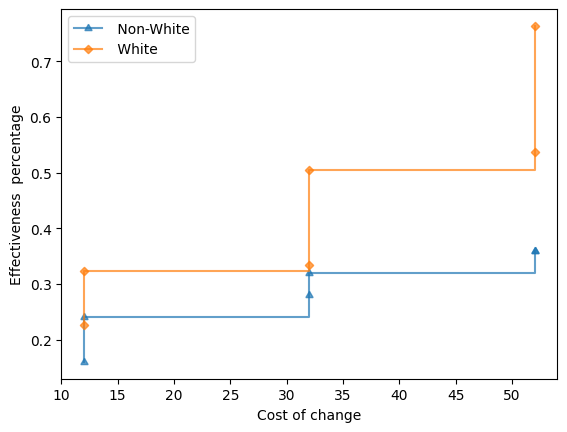

If age = (34.0, 41.0], occupation =  Machine-op-inspct, sex =  Male:
	Protected Subgroup ' Non-White', 1.03% covered out of 1763
		Make occupation =  Craft-repair with effectiveness 5.56% and counterfactual cost = 1.0.
		Make occupation =  Adm-clerical with effectiveness 5.56% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with effectiveness 11.11% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with effectiveness 11.11% and counterfactual cost = 1.0.
		Make occupation =  Sales with effectiveness 11.11% and counterfactual cost = 1.0.
		Make occupation =  Tech-support with effectiveness 11.11% and counterfactual cost = 1.0.
		Make age = (50.0, 90.0], occupation =  Craft-repair with effectiveness 11.11% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =  Prof-specialty with effectiveness 11.11% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Sales with effectiveness 11.11% and counterfactual cost = 2.0.
	

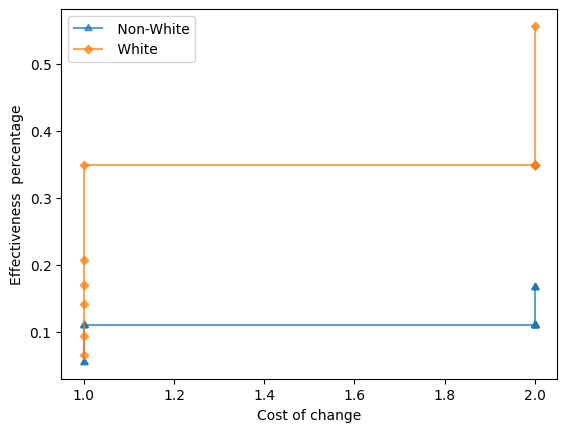

If Workclass =  Private, age = (41.0, 50.0], capital-gain = 0, capital-loss = 0, native-country =  United-States, occupation =  Craft-repair:
	Protected Subgroup ' Non-White', 1.26% covered out of 1763
		Make occupation =  Prof-specialty with effectiveness 9.09% and counterfactual cost = 1.0.
		Make occupation =  Sales with effectiveness 9.09% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with effectiveness 22.73% and counterfactual cost = 1.0.
		Make age = (50.0, 90.0], occupation =  Sales with effectiveness 22.73% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =  Prof-specialty with effectiveness 22.73% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =  Exec-managerial with effectiveness 22.73% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 0.23
	Protected Subgroup ' White', 2.13% covered out of 8978
		Make occupation =  Sales with effectiveness 11.46% and counterfactual cost = 1.0.
		Make occu

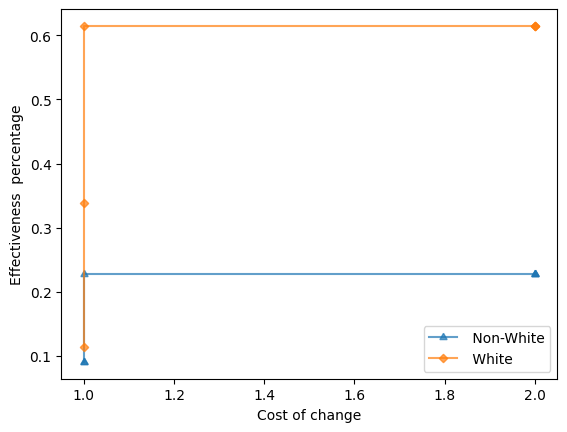

If age = (34.0, 41.0], education-num = 9, relationship =  Married, sex =  Male:
	Protected Subgroup ' Non-White', 1.72% covered out of 1763
		Make age = (41.0, 50.0] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make age = (50.0, 90.0] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make education-num = 10 with effectiveness 0.00% and counterfactual cost = 20.0.
		Make age = (50.0, 90.0], education-num = 10 with effectiveness 0.00% and counterfactual cost = 21.0.
		Make age = (41.0, 50.0], education-num = 10 with effectiveness 3.33% and counterfactual cost = 21.0.
		Make age = (41.0, 50.0], education-num = 11 with effectiveness 6.67% and counterfactual cost = 41.0.
		Aggregate cost of the above recourses = 0.07
	Protected Subgroup ' White', 3.04% covered out of 8978
		Make age = (50.0, 90.0] with effectiveness 1.09% and counterfactual cost = 1.0.
		Make age = (41.0, 50.0] with effectiveness 8.03% and counterfactual cost = 1.0.
		Make education-num = 10 with effect

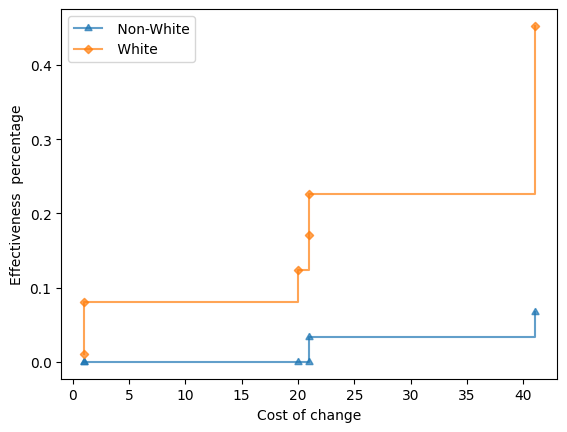

If age = (34.0, 41.0], capital-gain = 0, capital-loss = 0, education-num = 10, marital-status =  Married-civ-spouse, sex =  Male:
	Protected Subgroup ' Non-White', 1.03% covered out of 1763
		Make age = (50.0, 90.0] with effectiveness 5.56% and counterfactual cost = 1.0.
		Make age = (41.0, 50.0] with effectiveness 16.67% and counterfactual cost = 1.0.
		Make age = (41.0, 50.0], education-num = 11 with effectiveness 38.89% and counterfactual cost = 21.0.
		Make education-num = 12 with effectiveness 38.89% and counterfactual cost = 40.0.
		Make age = (41.0, 50.0], education-num = 12 with effectiveness 38.89% and counterfactual cost = 41.0.
		Aggregate cost of the above recourses = 0.39
	Protected Subgroup ' White', 1.29% covered out of 8978
		Make age = (50.0, 90.0] with effectiveness 4.31% and counterfactual cost = 1.0.
		Make age = (41.0, 50.0] with effectiveness 15.52% and counterfactual cost = 1.0.
		Make age = (41.0, 50.0], education-num = 11 with effectiveness 44.83% and counterfa

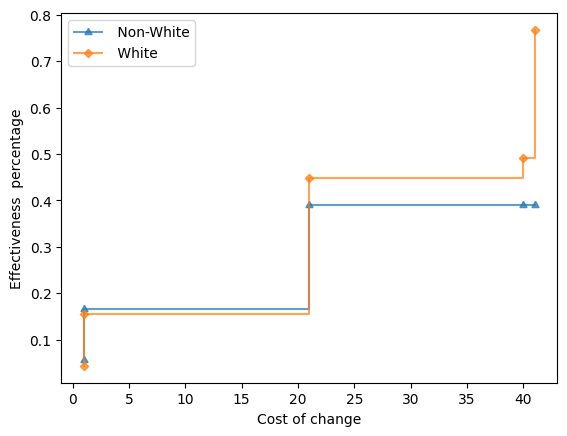

In [27]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="total-correctness",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        # "remove-fair-rules",
        # "keep-only-min-change"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric= True
)

## Fairness of Recourse at Coverage Level 

If education-num = 9, occupation =  Transport-moving:
	Protected Subgroup ' Non-White', 3.04% covered out of 1763
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Sales with effectiveness 3.77% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with effectiveness 16.98% and counterfactual cost = 1.0.
		Make education-num = 10, occupation =  Craft-repair with effectiveness 16.98% and counterfactual cost = 21.0.
		Make education-num = 10, occupation =  Adm-clerical with effectiveness 16.98% and counterfactual cost = 21.0.
		Make education-num = 10, occupation =  Sales with effectiveness 16.98% and counterfactual cost = 21.0.
		Make education-num = 10, occupation =  Prof-specialty with effectiveness 16.98% and counterfactual cost = 21.0.
		Make education-num = 10, occupation =  Exec-managerial with effectiveness 24.53% and counterfactual cost = 21.0.
		Make education-num = 11, occupation =  Exec-managerial with

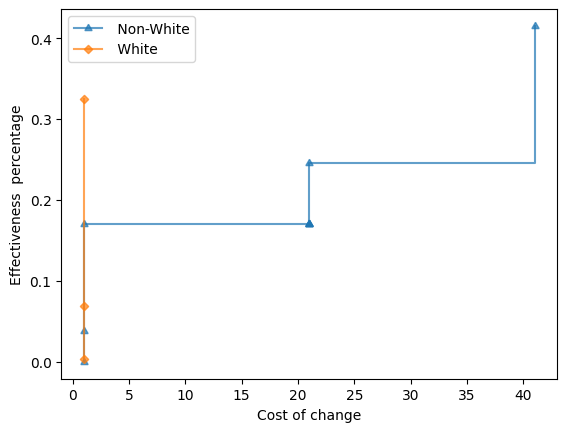

If education-num = 13, marital-status =  Divorced:
	Protected Subgroup ' Non-White', 1.55% covered out of 1763
		Make marital-status =  Married-civ-spouse with effectiveness 11.11% and counterfactual cost = 1.0.
		Make education-num = 14, marital-status =  Married-civ-spouse with effectiveness 22.22% and counterfactual cost = 21.0.
		Make education-num = 15, marital-status =  Married-civ-spouse with effectiveness 51.85% and counterfactual cost = 41.0.
		Aggregate cost of the above recourses = 41.00
	Protected Subgroup ' White', 1.92% covered out of 8978
		Make marital-status =  Married-civ-spouse with effectiveness 31.79% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Bias against  Non-White due to Equal Effectiveness. Unfairness score = 40.0.
	Cumulative effectiveness plot for the above recourses:


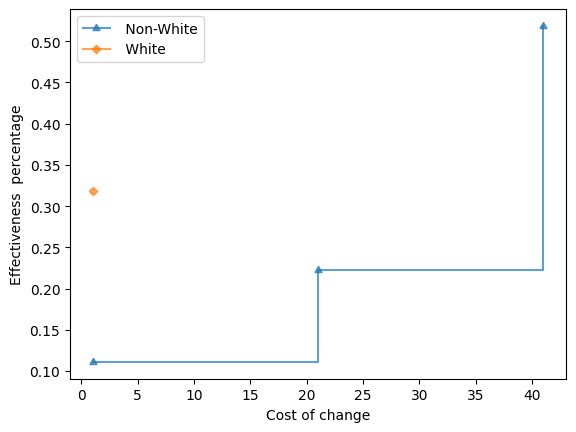

If Workclass =  Private, education-num = 10, marital-status =  Married-civ-spouse:
	Protected Subgroup ' Non-White', 4.19% covered out of 1763
		Make Workclass =  Self-emp-inc with effectiveness 13.70% and counterfactual cost = 1.0.
		Make Workclass =  Federal-gov with effectiveness 26.03% and counterfactual cost = 1.0.
		Make education-num = 11 with effectiveness 26.03% and counterfactual cost = 20.0.
		Make education-num = 12 with effectiveness 30.14% and counterfactual cost = 40.0.
		Aggregate cost of the above recourses = 40.00
	Protected Subgroup ' White', 5.20% covered out of 8978
		Make Workclass =  Self-emp-inc with effectiveness 17.91% and counterfactual cost = 1.0.
		Make Workclass =  Federal-gov with effectiveness 37.10% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Bias against  Non-White due to Equal Effectiveness. Unfairness score = 39.0.
	Cumulative effectiveness plot for the above recourses:


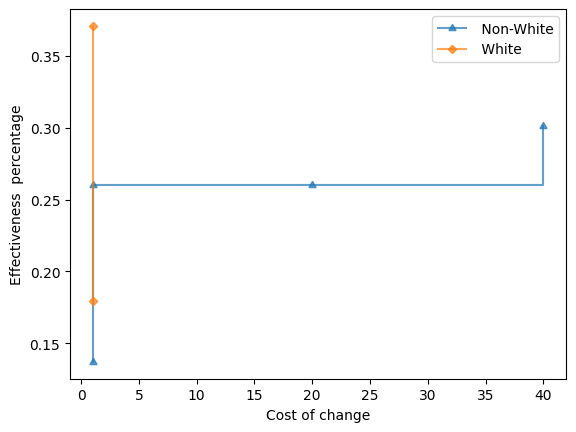

If Workclass =  Private, education-num = 10, relationship =  Married:
	Protected Subgroup ' Non-White', 3.96% covered out of 1763
		Make Workclass =  Self-emp-inc with effectiveness 14.49% and counterfactual cost = 1.0.
		Make Workclass =  Federal-gov with effectiveness 27.54% and counterfactual cost = 1.0.
		Make education-num = 11 with effectiveness 27.54% and counterfactual cost = 20.0.
		Make education-num = 12 with effectiveness 31.88% and counterfactual cost = 40.0.
		Aggregate cost of the above recourses = 40.00
	Protected Subgroup ' White', 5.10% covered out of 8978
		Make Workclass =  Self-emp-inc with effectiveness 18.26% and counterfactual cost = 1.0.
		Make Workclass =  Federal-gov with effectiveness 37.83% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Bias against  Non-White due to Equal Effectiveness. Unfairness score = 39.0.
	Cumulative effectiveness plot for the above recourses:


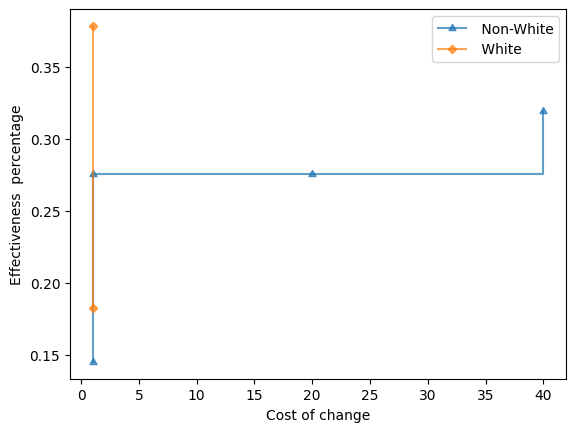

If Workclass =  Private, education-num = 10, marital-status =  Divorced, relationship =  Unmarried:
	Protected Subgroup ' Non-White', 1.09% covered out of 1763
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 10.53% and counterfactual cost = 11.0.
		Make Workclass =  Self-emp-inc, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 15.79% and counterfactual cost = 12.0.
		Make Workclass =  Federal-gov, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 21.05% and counterfactual cost = 12.0.
		Make education-num = 11, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 21.05% and counterfactual cost = 31.0.
		Make education-num = 12, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 31.58% and counterfactual cost = 51.0.
		Aggregate cost of the above recourses = 51.00
	Protected Subgroup ' White', 1.18% covered out of 8978
		Make m

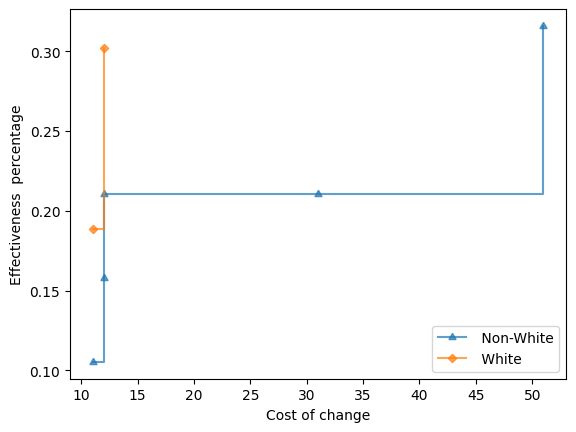

If education-num = 9, hours-per-week = FullTime, occupation =  Other-service, sex =  Male:
	Protected Subgroup ' Non-White', 2.29% covered out of 1763
		Make occupation =  Exec-managerial with effectiveness 2.50% and counterfactual cost = 1.0.
		Make occupation =  Craft-repair with effectiveness 2.50% and counterfactual cost = 1.0.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 30.00% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 2.00
	Protected Subgroup ' White', 1.09% covered out of 8978
		Make occupation =  Craft-repair with effectiveness 2.04% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with effectiveness 12.24% and counterfactual cost = 1.0.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 27.55% and counterfactual cost = 2.0.
		Make education-num = 10, occupation =  Exec-managerial with effectiveness 27.55% and counterfactual cost = 21.0.
		Make education-num =

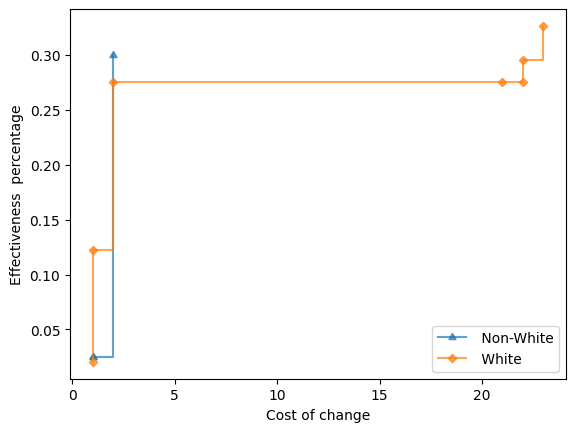

If Workclass =  Private, capital-gain = 0, education-num = 11, hours-per-week = FullTime, sex =  Male:
	Protected Subgroup ' Non-White', 1.09% covered out of 1763
		Make education-num = 12, hours-per-week = OverTime with effectiveness 15.79% and counterfactual cost = 21.0.
		Make education-num = 13 with effectiveness 15.79% and counterfactual cost = 40.0.
		Make education-num = 13, hours-per-week = OverTime with effectiveness 21.05% and counterfactual cost = 41.0.
		Make education-num = 13, hours-per-week = BrainDrain with effectiveness 21.05% and counterfactual cost = 42.0.
		Make Workclass =  Self-emp-inc, education-num = 13, hours-per-week = OverTime with effectiveness 42.11% and counterfactual cost = 42.0.
		Aggregate cost of the above recourses = 42.00
	Protected Subgroup ' White', 1.10% covered out of 8978
		Make education-num = 12, hours-per-week = OverTime with effectiveness 37.37% and counterfactual cost = 21.0.
		Aggregate cost of the above recourses = 21.00
	Bias against  No

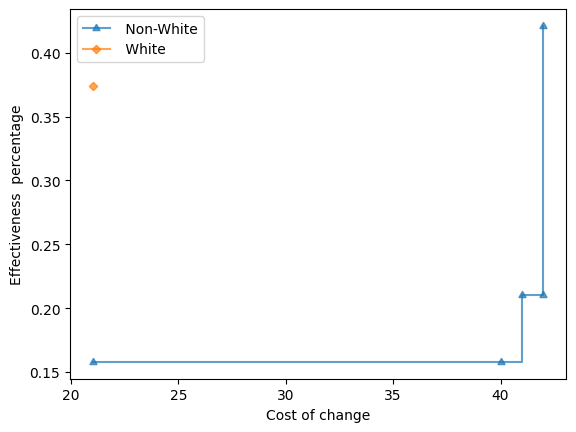

If Workclass =  Private, capital-loss = 0, education-num = 11, hours-per-week = FullTime, sex =  Male:
	Protected Subgroup ' Non-White', 1.03% covered out of 1763
		Make hours-per-week = OverTime with effectiveness 5.56% and counterfactual cost = 1.0.
		Make education-num = 12, hours-per-week = OverTime with effectiveness 16.67% and counterfactual cost = 21.0.
		Make education-num = 13 with effectiveness 16.67% and counterfactual cost = 40.0.
		Make Workclass =  Local-gov, education-num = 13 with effectiveness 16.67% and counterfactual cost = 41.0.
		Make education-num = 13, hours-per-week = OverTime with effectiveness 22.22% and counterfactual cost = 41.0.
		Make education-num = 13, hours-per-week = BrainDrain with effectiveness 22.22% and counterfactual cost = 42.0.
		Make Workclass =  Self-emp-inc, education-num = 13, hours-per-week = OverTime with effectiveness 38.89% and counterfactual cost = 42.0.
		Aggregate cost of the above recourses = 42.00
	Protected Subgroup ' White', 1.08%

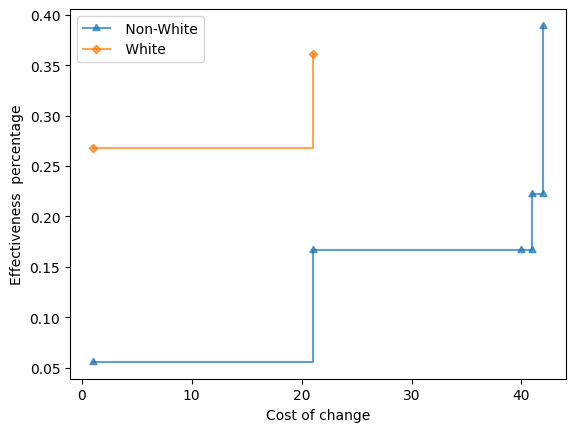

If capital-gain = 0, education-num = 11, hours-per-week = FullTime, sex =  Male:
	Protected Subgroup ' Non-White', 1.43% covered out of 1763
		Make education-num = 12 with effectiveness 8.00% and counterfactual cost = 20.0.
		Make education-num = 12, hours-per-week = OverTime with effectiveness 16.00% and counterfactual cost = 21.0.
		Make education-num = 13 with effectiveness 16.00% and counterfactual cost = 40.0.
		Make education-num = 13, hours-per-week = OverTime with effectiveness 24.00% and counterfactual cost = 41.0.
		Make capital-gain = 15024, education-num = 13, hours-per-week = OverTime with effectiveness 100.00% and counterfactual cost = 41.15.
		Aggregate cost of the above recourses = 41.15
	Protected Subgroup ' White', 1.41% covered out of 8978
		Make education-num = 12 with effectiveness 22.83% and counterfactual cost = 20.0.
		Make education-num = 12, hours-per-week = OverTime with effectiveness 33.86% and counterfactual cost = 21.0.
		Aggregate cost of the above recour

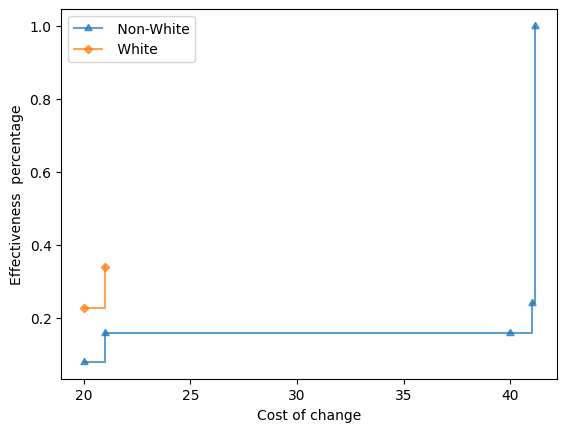

If Workclass =  Private, age = (26.0, 34.0], education-num = 10, sex =  Male:
	Protected Subgroup ' Non-White', 2.75% covered out of 1763
		Make age = (34.0, 41.0] with effectiveness 12.50% and counterfactual cost = 1.0.
		Make age = (41.0, 50.0] with effectiveness 20.83% and counterfactual cost = 1.0.
		Make age = (41.0, 50.0], education-num = 11 with effectiveness 29.17% and counterfactual cost = 21.0.
		Make age = (41.0, 50.0], education-num = 12 with effectiveness 31.25% and counterfactual cost = 41.0.
		Aggregate cost of the above recourses = 41.00
	Protected Subgroup ' White', 2.33% covered out of 8978
		Make age = (34.0, 41.0] with effectiveness 18.10% and counterfactual cost = 1.0.
		Make age = (41.0, 50.0] with effectiveness 21.90% and counterfactual cost = 1.0.
		Make age = (41.0, 50.0], education-num = 11 with effectiveness 34.29% and counterfactual cost = 21.0.
		Aggregate cost of the above recourses = 21.00
	Bias against  Non-White due to Equal Effectiveness. Unfairness sc

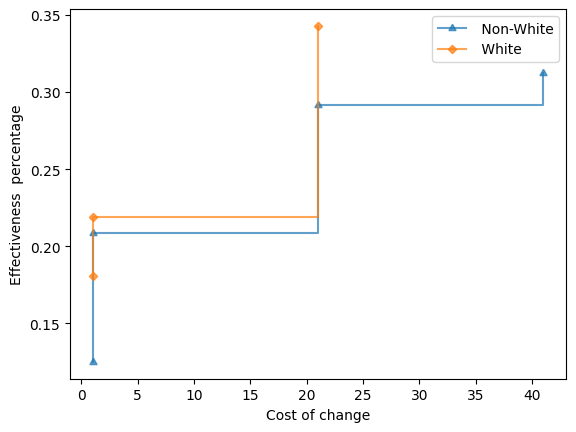

If age = (26.0, 34.0], education-num = 13, marital-status =  Never-married:
	Protected Subgroup ' Non-White', 2.75% covered out of 1763
		Make marital-status =  Married-civ-spouse with effectiveness 2.08% and counterfactual cost = 1.0.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse with effectiveness 14.58% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse with effectiveness 29.17% and counterfactual cost = 2.0.
		Make education-num = 14, marital-status =  Married-civ-spouse with effectiveness 29.17% and counterfactual cost = 21.0.
		Make age = (34.0, 41.0], education-num = 14, marital-status =  Married-civ-spouse with effectiveness 33.33% and counterfactual cost = 22.0.
		Aggregate cost of the above recourses = 22.00
	Protected Subgroup ' White', 2.11% covered out of 8978
		Make marital-status =  Married-civ-spouse with effectiveness 4.74% and counterfactual cost = 1.0.
		Make age = (34.0, 41.0], marital-status =  Married-c

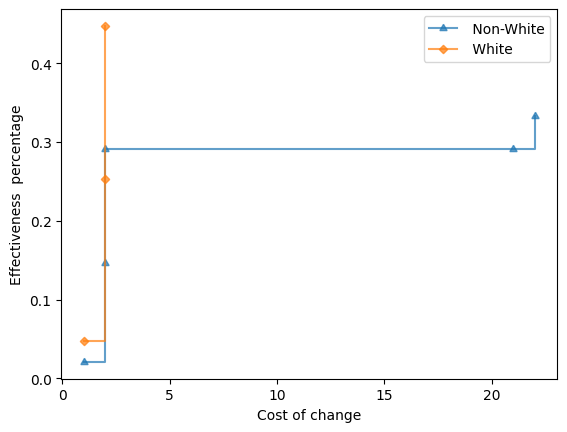

If education-num = 13, relationship =  Unmarried:
	Protected Subgroup ' Non-White', 2.70% covered out of 1763
		Make relationship =  Not-in-family with effectiveness 2.13% and counterfactual cost = 10.0.
		Make relationship =  Married with effectiveness 12.77% and counterfactual cost = 10.0.
		Make education-num = 14, relationship =  Not-in-family with effectiveness 12.77% and counterfactual cost = 30.0.
		Make education-num = 14, relationship =  Married with effectiveness 27.66% and counterfactual cost = 30.0.
		Make education-num = 15, relationship =  Married with effectiveness 36.17% and counterfactual cost = 50.0.
		Aggregate cost of the above recourses = 50.00
	Protected Subgroup ' White', 1.08% covered out of 8978
		Make relationship =  Not-in-family with effectiveness 3.09% and counterfactual cost = 10.0.
		Make relationship =  Married with effectiveness 18.56% and counterfactual cost = 10.0.
		Make education-num = 14, relationship =  Not-in-family with effectiveness 18.56% and 

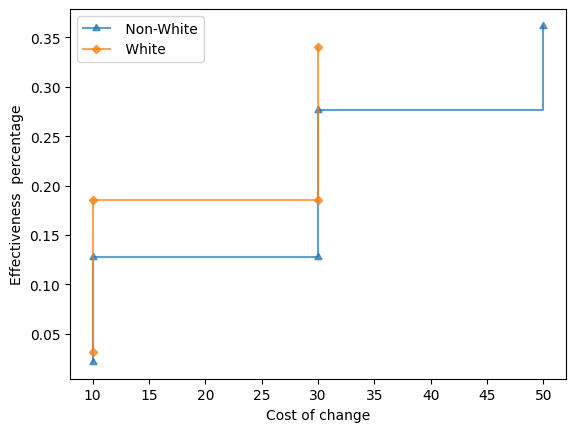

If education-num = 9, hours-per-week = FullTime, occupation =  Transport-moving:
	Protected Subgroup ' Non-White', 2.12% covered out of 1763
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with effectiveness 5.41% and counterfactual cost = 1.0.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 24.32% and counterfactual cost = 2.0.
		Make education-num = 10, occupation =  Exec-managerial with effectiveness 24.32% and counterfactual cost = 21.0.
		Make education-num = 10, hours-per-week = OverTime, occupation =  Sales with effectiveness 24.32% and counterfactual cost = 22.0.
		Make education-num = 10, hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 32.43% and counterfactual cost = 22.0.
		Aggregate cost of the above recourses = 22.00
	Protected Subgroup ' White', 1.25% covered out of 8978
		Make occupation =  Craft-repair with effectiveness 0.88% and

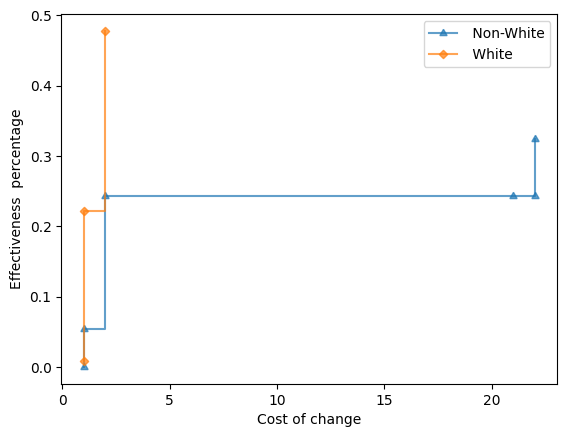

If education-num = 9, marital-status =  Married-civ-spouse, occupation =  Craft-repair:
	Protected Subgroup ' Non-White', 2.07% covered out of 1763
		Make occupation =  Sales with effectiveness 2.78% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with effectiveness 11.11% and counterfactual cost = 1.0.
		Make education-num = 10 with effectiveness 11.11% and counterfactual cost = 20.0.
		Make education-num = 10, occupation =  Sales with effectiveness 11.11% and counterfactual cost = 21.0.
		Make education-num = 10, occupation =  Adm-clerical with effectiveness 11.11% and counterfactual cost = 21.0.
		Make education-num = 10, occupation =  Prof-specialty with effectiveness 11.11% and counterfactual cost = 21.0.
		Make education-num = 10, occupation =  Exec-managerial with effectiveness 36.11% and counterfactual cost = 21.0.
		Aggregate cost of the above recourses = 21.00
	Protected Subgroup ' White', 4.51% covered out of 8978
		Make occupation =  Sales with effective

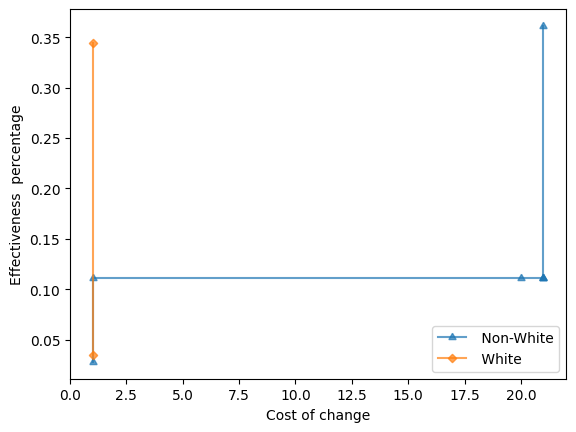

If education-num = 9, occupation =  Craft-repair, relationship =  Married:
	Protected Subgroup ' Non-White', 2.01% covered out of 1763
		Make occupation =  Sales with effectiveness 2.86% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with effectiveness 11.43% and counterfactual cost = 1.0.
		Make education-num = 10 with effectiveness 11.43% and counterfactual cost = 20.0.
		Make education-num = 10, occupation =  Sales with effectiveness 11.43% and counterfactual cost = 21.0.
		Make education-num = 10, occupation =  Adm-clerical with effectiveness 11.43% and counterfactual cost = 21.0.
		Make education-num = 10, occupation =  Prof-specialty with effectiveness 11.43% and counterfactual cost = 21.0.
		Make education-num = 10, occupation =  Exec-managerial with effectiveness 37.14% and counterfactual cost = 21.0.
		Aggregate cost of the above recourses = 21.00
	Protected Subgroup ' White', 4.49% covered out of 8978
		Make occupation =  Sales with effectiveness 3.46% an

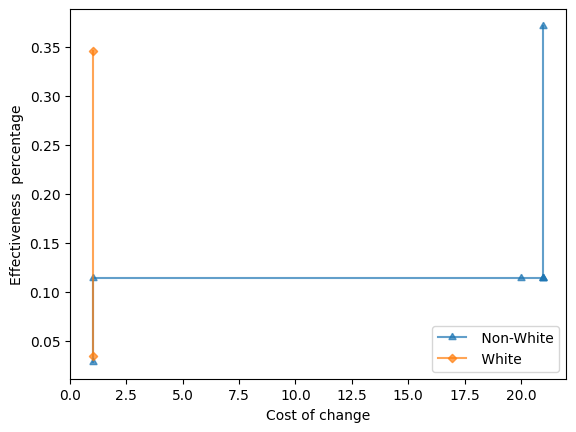

If education-num = 9, occupation =  Machine-op-inspct, sex =  Male:
	Protected Subgroup ' Non-White', 2.01% covered out of 1763
		Make occupation =  Exec-managerial with effectiveness 5.71% and counterfactual cost = 1.0.
		Make occupation =  Craft-repair with effectiveness 5.71% and counterfactual cost = 1.0.
		Make occupation =  Sales with effectiveness 5.71% and counterfactual cost = 1.0.
		Make education-num = 10, occupation =  Sales with effectiveness 5.71% and counterfactual cost = 21.0.
		Make education-num = 10, occupation =  Craft-repair with effectiveness 5.71% and counterfactual cost = 21.0.
		Make education-num = 10, occupation =  Prof-specialty with effectiveness 5.71% and counterfactual cost = 21.0.
		Make education-num = 10, occupation =  Exec-managerial with effectiveness 20.00% and counterfactual cost = 21.0.
		Make education-num = 11, occupation =  Exec-managerial with effectiveness 31.43% and counterfactual cost = 41.0.
		Aggregate cost of the above recourses = 41.00


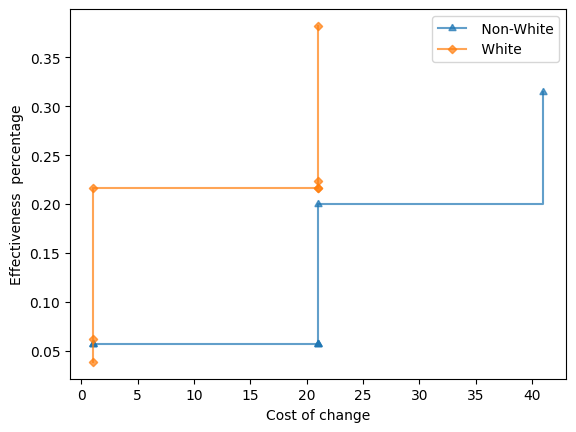

If capital-gain = 0, education-num = 10, occupation =  Craft-repair:
	Protected Subgroup ' Non-White', 1.89% covered out of 1763
		Make occupation =  Sales with effectiveness 6.06% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with effectiveness 9.09% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with effectiveness 27.27% and counterfactual cost = 1.0.
		Make education-num = 11, occupation =  Exec-managerial with effectiveness 33.33% and counterfactual cost = 21.0.
		Aggregate cost of the above recourses = 21.00
	Protected Subgroup ' White', 3.08% covered out of 8978
		Make occupation =  Sales with effectiveness 12.23% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with effectiveness 21.94% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with effectiveness 40.65% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Bias against  Non-White due to Equal Effectiveness. Unfairness s

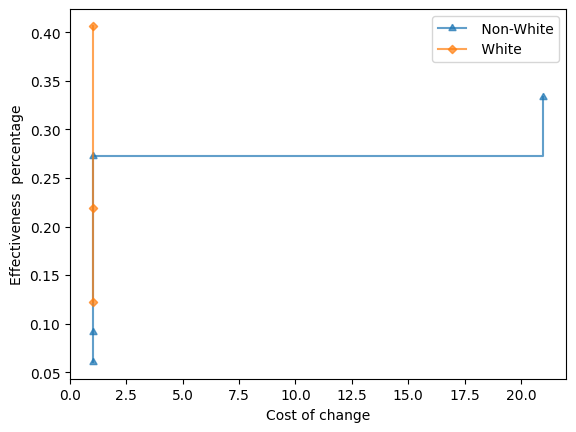

In [28]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="min-above-corr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "keep-cheap-rules-above-thr-cor",
        # "keep-only-min-change",
        
    ],
    cor_threshold = 0.3,
    params=params
)

pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric=False
)

## Fairness of Coverage at Recourse Budget

If age = (34.0, 41.0], capital-loss = 0, native-country =  United-States, occupation =  Machine-op-inspct:
	Protected Subgroup ' Non-White', 1.38% covered out of 1763
		Make occupation =  Exec-managerial with effectiveness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with effectiveness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Sales with effectiveness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Adm-clerical with effectiveness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Tech-support with effectiveness 0.00% and counterfactual cost = 1.0.
		Make age = (41.0, 50.0], occupation =  Exec-managerial with effectiveness 0.00% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Prof-specialty with effectiveness 0.00% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =  Exec-managerial with effectiv

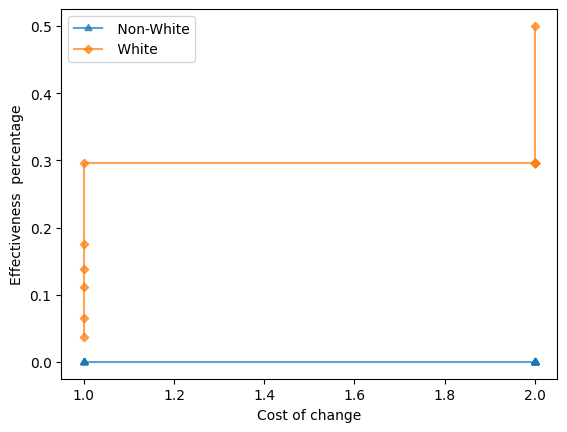

If age = (34.0, 41.0], capital-gain = 0, capital-loss = 0, marital-status =  Married-civ-spouse, occupation =  Craft-repair:
	Protected Subgroup ' Non-White', 1.09% covered out of 1763
		Make occupation =  Sales with effectiveness 0.00% and counterfactual cost = 1.0.
		Make age = (41.0, 50.0] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with effectiveness 5.26% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with effectiveness 10.53% and counterfactual cost = 1.0.
		Make age = (50.0, 90.0], occupation =  Sales with effectiveness 10.53% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Adm-clerical with effectiveness 10.53% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =  Prof-specialty with effectiveness 10.53% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Sales with effectiveness 10.53% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occup

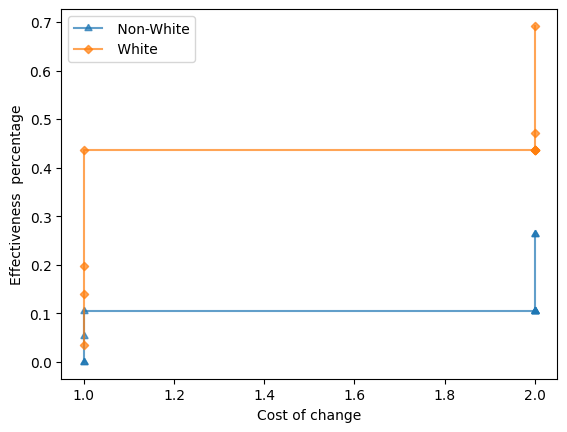

If Workclass =  Self-emp-not-inc, capital-loss = 0, native-country =  United-States, relationship =  Married, sex =  Male:
	Protected Subgroup ' Non-White', 1.09% covered out of 1763
		Make Workclass =  Local-gov with effectiveness 5.26% and counterfactual cost = 1.0.
		Make Workclass =  State-gov with effectiveness 5.26% and counterfactual cost = 1.0.
		Make Workclass =  Private with effectiveness 10.53% and counterfactual cost = 1.0.
		Make Workclass =  Self-emp-inc with effectiveness 26.32% and counterfactual cost = 1.0.
		Make Workclass =  Federal-gov with effectiveness 26.32% and counterfactual cost = 1.0.
		Make Workclass =  Private, capital-loss = 1887 with effectiveness 31.58% and counterfactual cost = 1.43.
		Make Workclass =  Private, capital-loss = 1902 with effectiveness 31.58% and counterfactual cost = 1.44.
		Make Workclass =  Private, capital-loss = 1977 with effectiveness 31.58% and counterfactual cost = 1.45.
		Aggregate cost of the above recourses = 0.32
	Protected Su

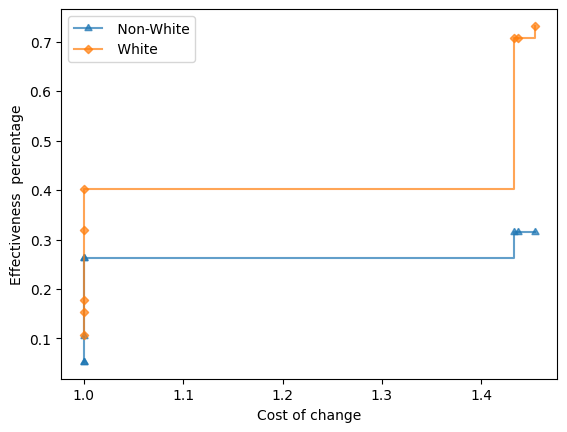

If age = (34.0, 41.0], capital-loss = 0, occupation =  Craft-repair, relationship =  Married:
	Protected Subgroup ' Non-White', 1.03% covered out of 1763
		Make occupation =  Sales with effectiveness 0.00% and counterfactual cost = 1.0.
		Make age = (41.0, 50.0] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Adm-clerical with effectiveness 0.00% and counterfactual cost = 1.0.
		Make age = (50.0, 90.0] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with effectiveness 5.56% and counterfactual cost = 1.0.
		Make occupation =  Tech-support with effectiveness 5.56% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with effectiveness 11.11% and counterfactual cost = 1.0.
		Make age = (50.0, 90.0], occupation =  Sales with effectiveness 11.11% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Adm-clerical with effectiveness 11.11% and counterfactual cost = 2.0.
		Make age = (50.0

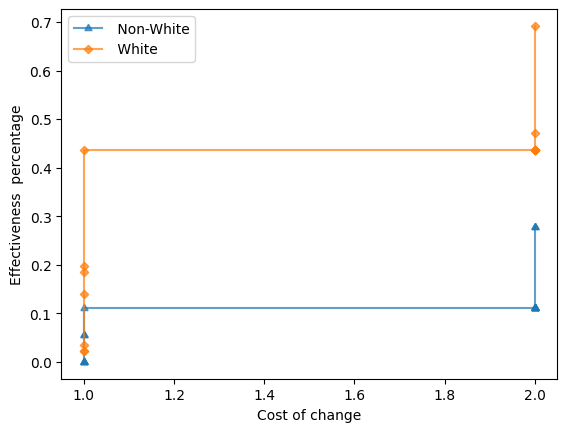

If age = (34.0, 41.0], occupation =  Machine-op-inspct, sex =  Male:
	Protected Subgroup ' Non-White', 1.03% covered out of 1763
		Make occupation =  Craft-repair with effectiveness 5.56% and counterfactual cost = 1.0.
		Make occupation =  Adm-clerical with effectiveness 5.56% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with effectiveness 11.11% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with effectiveness 11.11% and counterfactual cost = 1.0.
		Make occupation =  Sales with effectiveness 11.11% and counterfactual cost = 1.0.
		Make occupation =  Tech-support with effectiveness 11.11% and counterfactual cost = 1.0.
		Make age = (50.0, 90.0], occupation =  Craft-repair with effectiveness 11.11% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =  Prof-specialty with effectiveness 11.11% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Sales with effectiveness 11.11% and counterfactual cost = 2.0.
	

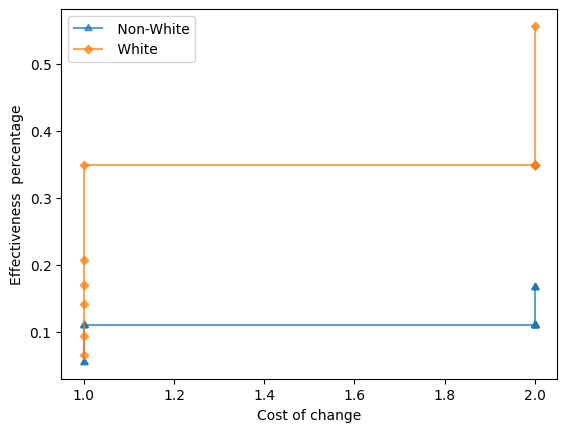

If Workclass =  Private, age = (41.0, 50.0], capital-gain = 0, capital-loss = 0, native-country =  United-States, occupation =  Craft-repair:
	Protected Subgroup ' Non-White', 1.26% covered out of 1763
		Make occupation =  Prof-specialty with effectiveness 9.09% and counterfactual cost = 1.0.
		Make occupation =  Sales with effectiveness 9.09% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with effectiveness 22.73% and counterfactual cost = 1.0.
		Make age = (50.0, 90.0], occupation =  Sales with effectiveness 22.73% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =  Prof-specialty with effectiveness 22.73% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =  Exec-managerial with effectiveness 22.73% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 0.23
	Protected Subgroup ' White', 2.13% covered out of 8978
		Make occupation =  Sales with effectiveness 11.46% and counterfactual cost = 1.0.
		Make occu

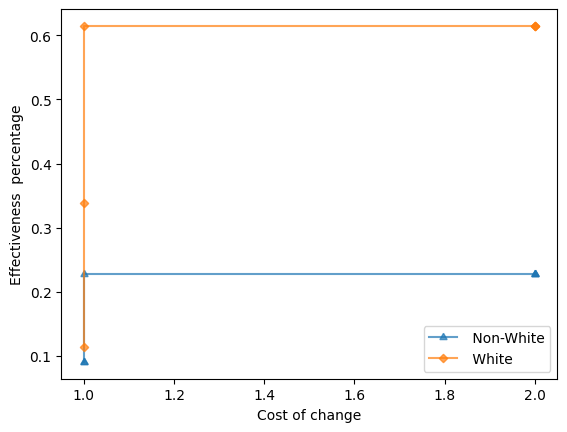

If education-num = 14, marital-status =  Never-married:
	Protected Subgroup ' Non-White', 1.15% covered out of 1763
		Make marital-status =  Married-civ-spouse with effectiveness 5.00% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 0.05
	Protected Subgroup ' White', 1.56% covered out of 8978
		Make marital-status =  Married-civ-spouse with effectiveness 41.13% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 0.41
	Bias against  Non-White due to Equal Effectiveness. Unfairness score = 0.361.
	Cumulative effectiveness plot for the above recourses:


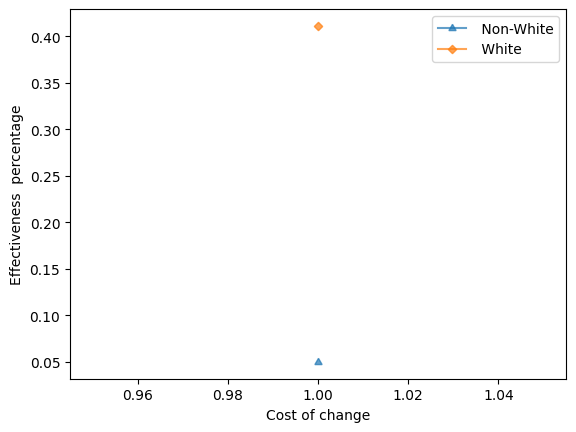

If Workclass =  Private, hours-per-week = PartTime, marital-status =  Married-civ-spouse, native-country =  United-States:
	Protected Subgroup ' Non-White', 1.09% covered out of 1763
		Make hours-per-week = MidTime with effectiveness 0.00% and counterfactual cost = 1.0.
		Make hours-per-week = FullTime with effectiveness 0.00% and counterfactual cost = 2.0.
		Make Workclass =  Local-gov, hours-per-week = FullTime with effectiveness 0.00% and counterfactual cost = 3.0.
		Make Workclass =  Self-emp-inc, hours-per-week = FullTime with effectiveness 0.00% and counterfactual cost = 3.0.
		Make Workclass =  State-gov, hours-per-week = FullTime with effectiveness 0.00% and counterfactual cost = 3.0.
		Make Workclass =  Self-emp-not-inc, hours-per-week = FullTime with effectiveness 0.00% and counterfactual cost = 3.0.
		Make hours-per-week = OverTime with effectiveness 5.26% and counterfactual cost = 3.0.
		Make Workclass =  Federal-gov, hours-per-week = FullTime with effectiveness 5.26% and c

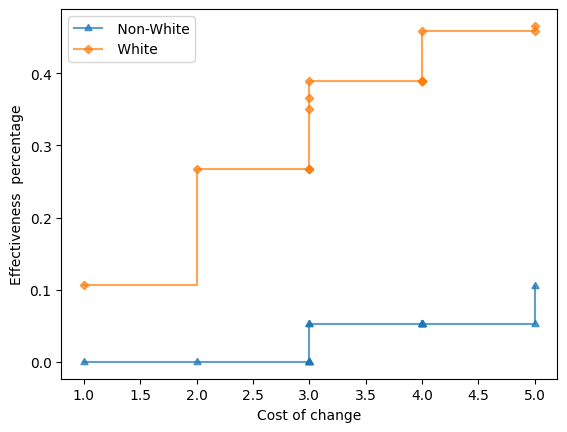

If age = (41.0, 50.0], capital-gain = 0, capital-loss = 0, marital-status =  Married-civ-spouse, occupation =  Craft-repair:
	Protected Subgroup ' Non-White', 1.15% covered out of 1763
		Make occupation =  Adm-clerical with effectiveness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with effectiveness 10.00% and counterfactual cost = 1.0.
		Make occupation =  Sales with effectiveness 10.00% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with effectiveness 35.00% and counterfactual cost = 1.0.
		Make age = (50.0, 90.0], occupation =  Sales with effectiveness 35.00% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =  Prof-specialty with effectiveness 35.00% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =  Exec-managerial with effectiveness 35.00% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 0.35
	Protected Subgroup ' White', 2.14% covered out of 8978
		Make occupation = 

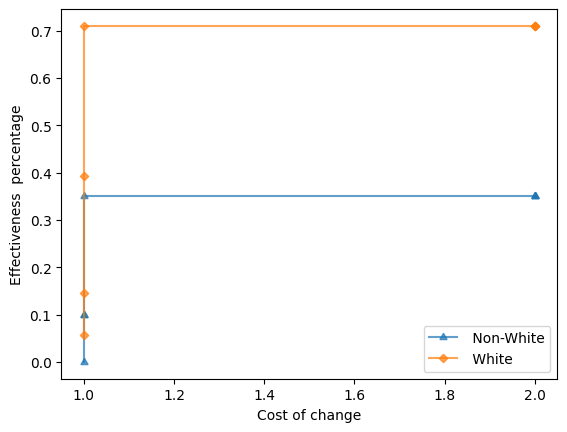

If age = (26.0, 34.0], capital-gain = 0, marital-status =  Married-civ-spouse, occupation =  Craft-repair:
	Protected Subgroup ' Non-White', 1.15% covered out of 1763
		Make occupation =  Sales with effectiveness 5.00% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with effectiveness 10.00% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with effectiveness 10.00% and counterfactual cost = 1.0.
		Make age = (41.0, 50.0] with effectiveness 10.00% and counterfactual cost = 1.0.
		Make age = (34.0, 41.0], occupation =  Sales with effectiveness 10.00% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Adm-clerical with effectiveness 10.00% and counterfactual cost = 2.0.
		Make age = (34.0, 41.0], occupation =  Prof-specialty with effectiveness 20.00% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Sales with effectiveness 20.00% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Exec-ma

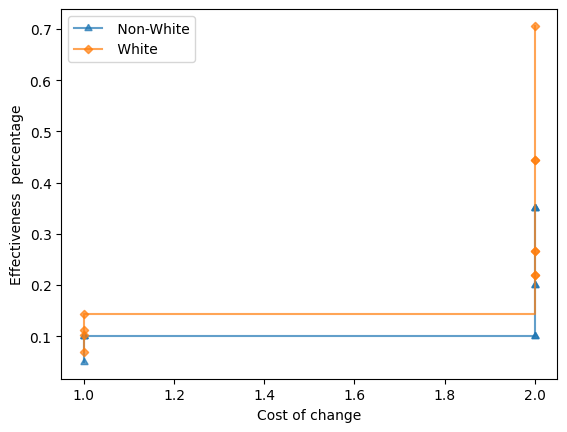

If Workclass =  Private, age = (34.0, 41.0], capital-gain = 0, capital-loss = 0, native-country =  United-States, occupation =  Craft-repair, sex =  Male:
	Protected Subgroup ' Non-White', 1.26% covered out of 1763
		Make occupation =  Sales with effectiveness 0.00% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with effectiveness 4.55% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with effectiveness 9.09% and counterfactual cost = 1.0.
		Make age = (50.0, 90.0], occupation =  Sales with effectiveness 9.09% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Sales with effectiveness 9.09% and counterfactual cost = 2.0.
		Make age = (50.0, 90.0], occupation =  Prof-specialty with effectiveness 9.09% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Prof-specialty with effectiveness 9.09% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Exec-managerial with effectiveness 18.18% and 

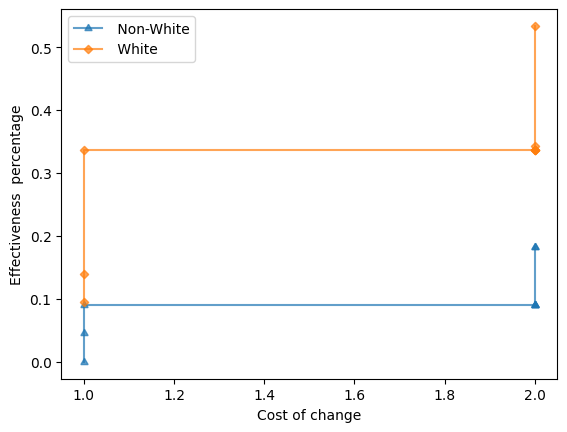

If age = (26.0, 34.0], capital-gain = 0, occupation =  Craft-repair, relationship =  Married:
	Protected Subgroup ' Non-White', 1.09% covered out of 1763
		Make occupation =  Sales with effectiveness 5.26% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with effectiveness 10.53% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with effectiveness 10.53% and counterfactual cost = 1.0.
		Make age = (41.0, 50.0] with effectiveness 10.53% and counterfactual cost = 1.0.
		Make age = (34.0, 41.0], occupation =  Sales with effectiveness 10.53% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Adm-clerical with effectiveness 10.53% and counterfactual cost = 2.0.
		Make age = (34.0, 41.0], occupation =  Prof-specialty with effectiveness 21.05% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Sales with effectiveness 21.05% and counterfactual cost = 2.0.
		Make age = (41.0, 50.0], occupation =  Exec-managerial with

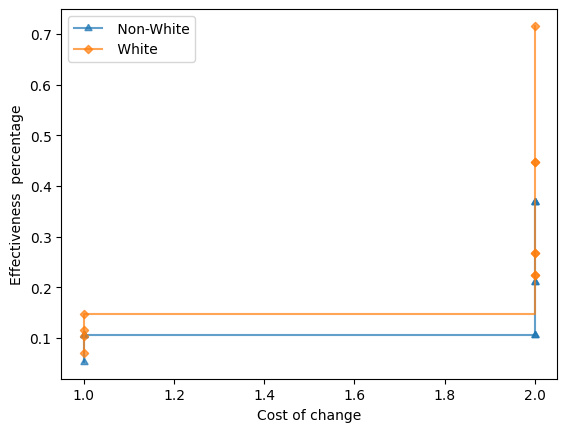

If age = (34.0, 41.0], capital-gain = 0, education-num = 9, occupation =  Craft-repair:
	Protected Subgroup ' Non-White', 1.15% covered out of 1763
		Make occupation =  Exec-managerial with effectiveness 5.00% and counterfactual cost = 1.0.
		Make age = (41.0, 50.0], occupation =  Exec-managerial with effectiveness 10.00% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 0.10
	Protected Subgroup ' White', 1.42% covered out of 8978
		Make occupation =  Exec-managerial with effectiveness 20.31% and counterfactual cost = 1.0.
		Make age = (41.0, 50.0], occupation =  Exec-managerial with effectiveness 44.53% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 0.45
	Bias against  Non-White due to Equal Effectiveness. Unfairness score = 0.345.
	Cumulative effectiveness plot for the above recourses:


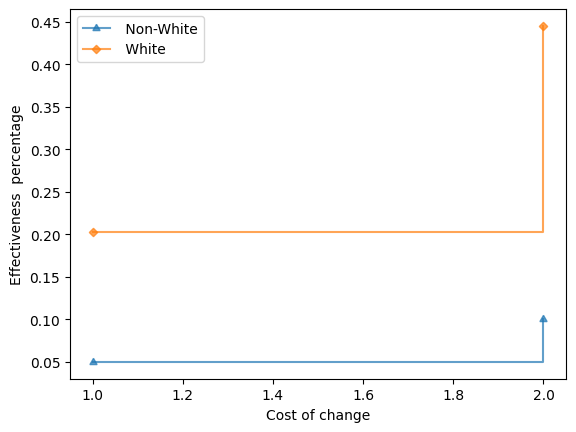

In [29]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="max-upto-cost",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "remove-above-thr-cost"
        #"remove-below-thr",
        #"keep-only-min-change",
        
    ],
    cost_threshold = 10,
    params=params
)

pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric = True
)

## Fairness of Recourse

In [ ]:
2598 / (2598 + 8977), 244 / (244 + 1748)

(0.22444924406047517, 0.12248995983935743)

In [ ]:
pd.DataFrame({"race": X_test.race, "pred": preds_Xtest}).value_counts()

race        pred
 White      0.0     8977
            1.0     2598
 Non-White  0.0     1748
            1.0      244
dtype: int64

If capital-gain = 0, capital-loss = 0, marital-status =  Never-married, relationship =  Own-child:
	Protected Subgroup ' Non-White', 15.43% covered out of 1748
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 7.45% and counterfactual cost = 11.0.
		Make capital-gain = 3103, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 25.88% and counterfactual cost = 11.03.
		Make capital-gain = 4386, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 32.94% and counterfactual cost = 11.04.
		Make capital-gain = 5178, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 45.10% and counterfactual cost = 11.05.
		Make capital-gain = 7298, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 66.67% and counterfactual cost = 11.07.
		Make capital-gain = 7688, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 74.51% an

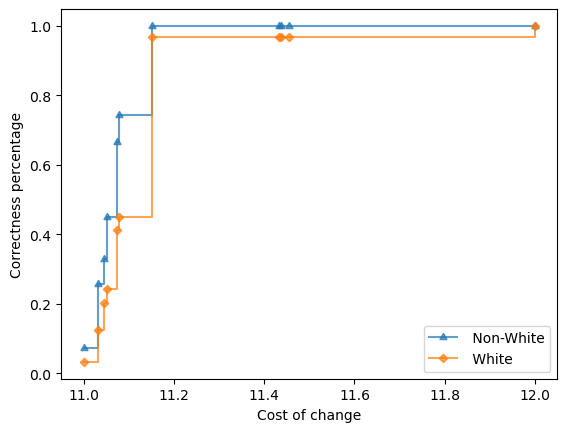

If capital-gain = 0, marital-status =  Never-married, relationship =  Own-child:
	Protected Subgroup ' Non-White', 15.73% covered out of 1748
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 8.08% and counterfactual cost = 11.0.
		Make capital-gain = 3103, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 26.54% and counterfactual cost = 11.03.
		Make capital-gain = 4386, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 33.46% and counterfactual cost = 11.04.
		Make capital-gain = 5178, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 45.38% and counterfactual cost = 11.05.
		Make capital-gain = 7298, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 66.92% and counterfactual cost = 11.07.
		Make capital-gain = 7688, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 74.62% and counterfactual c

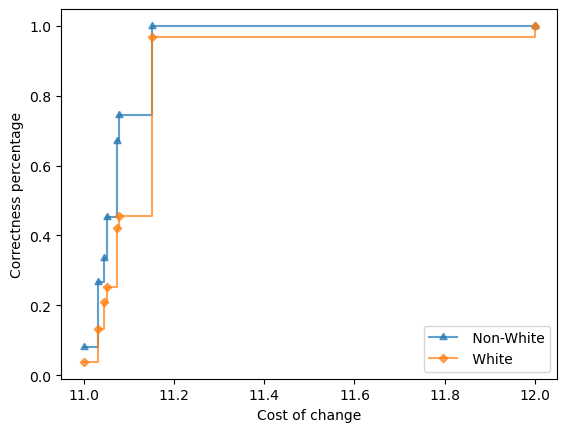

If capital-gain = 0, capital-loss = 0, marital-status =  Never-married, native-country =  United-States, relationship =  Own-child:
	Protected Subgroup ' Non-White', 13.01% covered out of 1748
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 7.44% and counterfactual cost = 11.0.
		Make capital-gain = 3103, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 27.44% and counterfactual cost = 11.03.
		Make capital-gain = 4386, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 35.35% and counterfactual cost = 11.04.
		Make capital-gain = 5178, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 48.37% and counterfactual cost = 11.05.
		Make capital-gain = 7298, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 66.51% and counterfactual cost = 11.07.
		Make capital-gain = 7688, marital-status =  Married-civ-spouse, relationship =  Mar

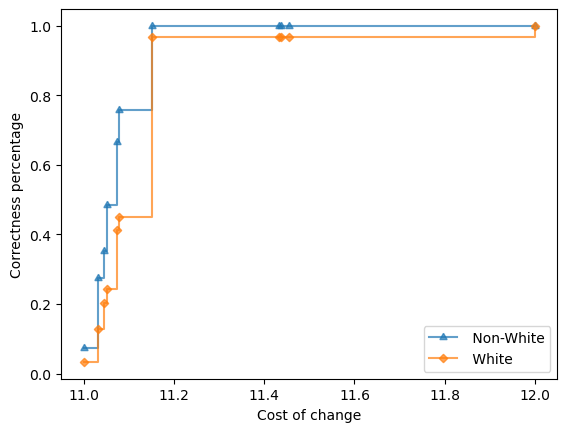

If capital-gain = 0, marital-status =  Never-married, native-country =  United-States, relationship =  Own-child:
	Protected Subgroup ' Non-White', 13.25% covered out of 1748
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 8.22% and counterfactual cost = 11.0.
		Make capital-gain = 3103, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 27.85% and counterfactual cost = 11.03.
		Make capital-gain = 4386, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 35.62% and counterfactual cost = 11.04.
		Make capital-gain = 5178, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 48.40% and counterfactual cost = 11.05.
		Make capital-gain = 7298, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 66.67% and counterfactual cost = 11.07.
		Make capital-gain = 7688, marital-status =  Married-civ-spouse, relationship =  Married with effectiv

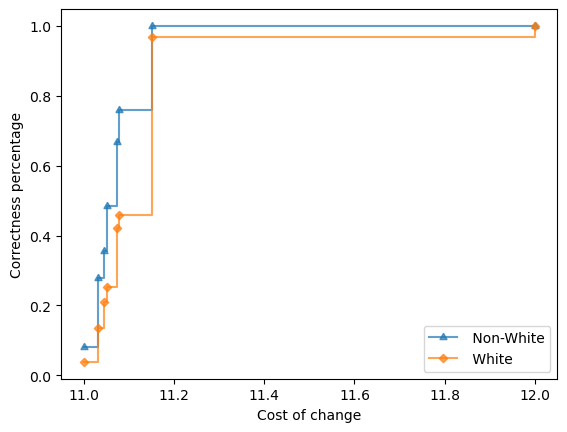

If Workclass =  Private, capital-gain = 0, capital-loss = 0, marital-status =  Never-married, relationship =  Own-child:
	Protected Subgroup ' Non-White', 13.07% covered out of 1748
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 6.94% and counterfactual cost = 11.0.
		Make capital-gain = 7298, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 63.89% and counterfactual cost = 11.07.
		Make capital-gain = 7688, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 73.15% and counterfactual cost = 11.08.
		Make capital-gain = 15024, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 100.00% and counterfactual cost = 11.15.
		Make capital-loss = 1887, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 100.00% and counterfactual cost = 11.43.
		Make capital-loss = 1902, marital-status =  Married-civ-spouse, relationship =  Married wit

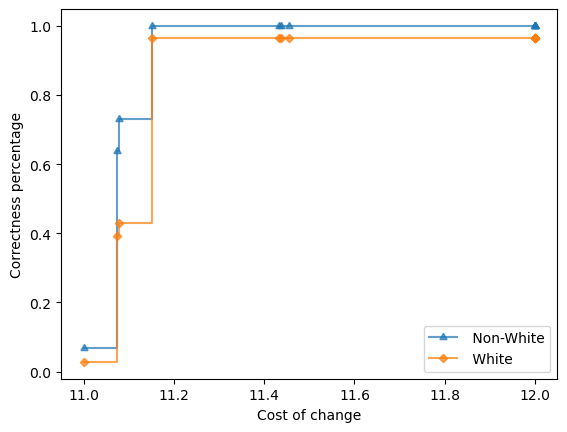

If Workclass =  Private, capital-gain = 0, marital-status =  Never-married, relationship =  Own-child:
	Protected Subgroup ' Non-White', 13.37% covered out of 1748
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 7.69% and counterfactual cost = 11.0.
		Make capital-gain = 7298, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 64.25% and counterfactual cost = 11.07.
		Make capital-gain = 7688, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 73.30% and counterfactual cost = 11.08.
		Make capital-gain = 15024, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 100.00% and counterfactual cost = 11.15.
		Make Workclass =  Self-emp-not-inc, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 100.00% and counterfactual cost = 12.0.
		Make Workclass =  State-gov, marital-status =  Married-civ-spouse, relationship =  Married with effe

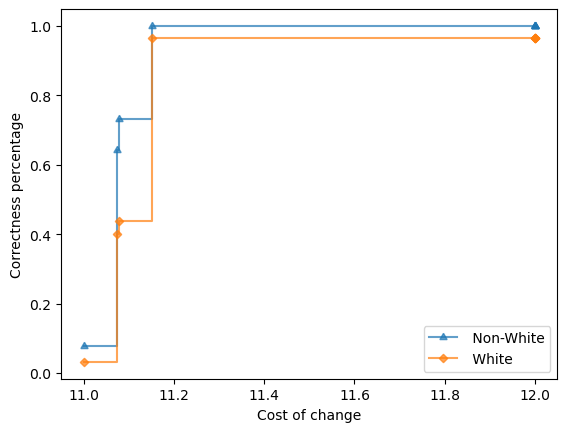

If Workclass =  Private, capital-gain = 0, capital-loss = 0, marital-status =  Never-married, native-country =  United-States, relationship =  Own-child:
	Protected Subgroup ' Non-White', 10.77% covered out of 1748
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 6.74% and counterfactual cost = 11.0.
		Make capital-gain = 7298, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 62.92% and counterfactual cost = 11.07.
		Make capital-gain = 7688, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 74.16% and counterfactual cost = 11.08.
		Make capital-gain = 15024, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 100.00% and counterfactual cost = 11.15.
		Make capital-loss = 1887, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 100.00% and counterfactual cost = 11.43.
		Make capital-loss = 1902, marital-status =  Married-civ-sp

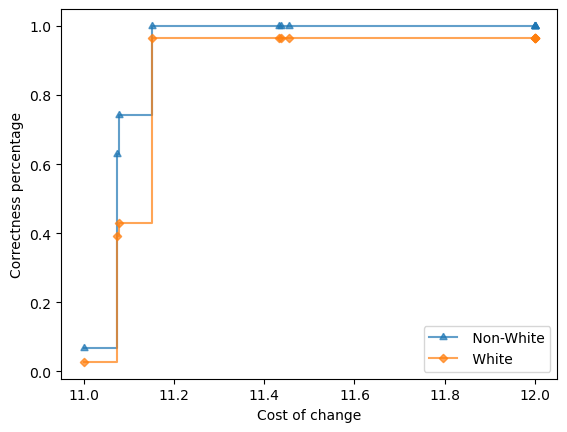

If Workclass =  Private, capital-gain = 0, marital-status =  Never-married, native-country =  United-States, relationship =  Own-child:
	Protected Subgroup ' Non-White', 11.01% covered out of 1748
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 7.69% and counterfactual cost = 11.0.
		Make capital-gain = 7298, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 63.19% and counterfactual cost = 11.07.
		Make capital-gain = 7688, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 74.18% and counterfactual cost = 11.08.
		Make capital-gain = 15024, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 100.00% and counterfactual cost = 11.15.
		Make Workclass =  Self-emp-not-inc, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 100.00% and counterfactual cost = 12.0.
		Make Workclass =  State-gov, marital-status =  Married-civ-spouse, 

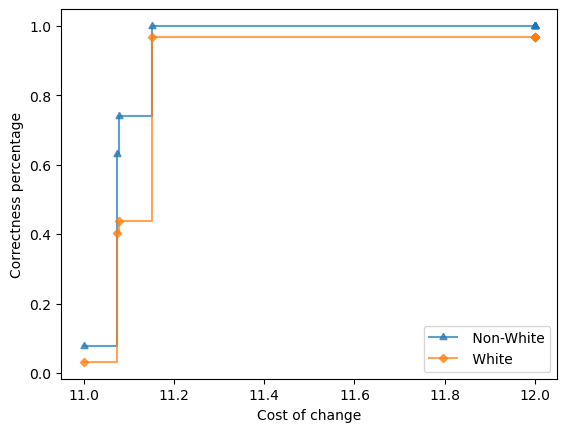

If capital-gain = 0, marital-status =  Never-married, occupation =  Other-service:
	Protected Subgroup ' Non-White', 8.11% covered out of 1748
		Make marital-status =  Married-civ-spouse, occupation =  Transport-moving with effectiveness 0.75% and counterfactual cost = 2.0.
		Make marital-status =  Married-civ-spouse, occupation =  Sales with effectiveness 1.49% and counterfactual cost = 2.0.
		Make marital-status =  Married-civ-spouse, occupation =  Craft-repair with effectiveness 1.49% and counterfactual cost = 2.0.
		Make marital-status =  Married-civ-spouse, occupation =  Adm-clerical with effectiveness 1.49% and counterfactual cost = 2.0.
		Make marital-status =  Married-civ-spouse, occupation =  Protective-serv with effectiveness 1.49% and counterfactual cost = 2.0.
		Make marital-status =  Married-civ-spouse, occupation =  Prof-specialty with effectiveness 2.99% and counterfactual cost = 2.0.
		Make marital-status =  Married-civ-spouse, occupation =  Tech-support with effectiven

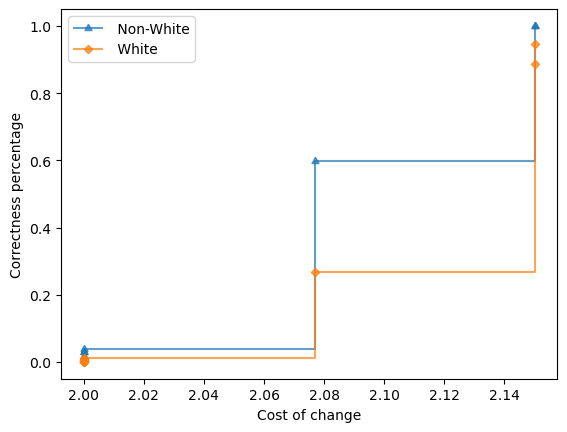

If capital-gain = 0, native-country =  United-States:
	Protected Subgroup ' Non-White', 76.71% covered out of 1748
		Make capital-gain = 3103 with effectiveness 11.04% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 17.74% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 22.00% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 34.23% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 36.91% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 83.36% and counterfactual cost = 0.15.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
	Protected Subgroup ' White', 89.26% covered out of 8977
		Make capital-gain = 3103 with effectiveness 20.14% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 27.47% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 32.24% and coun

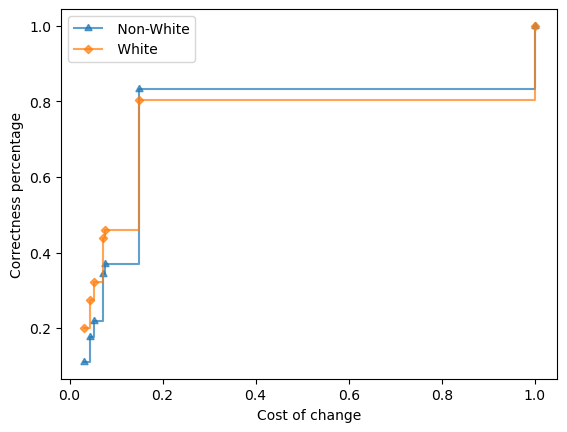

If capital-gain = 0, capital-loss = 0, marital-status =  Never-married, occupation =  Other-service:
	Protected Subgroup ' Non-White', 7.86% covered out of 1748
		Make marital-status =  Married-civ-spouse, occupation =  Sales with effectiveness 0.77% and counterfactual cost = 2.0.
		Make marital-status =  Married-civ-spouse, occupation =  Adm-clerical with effectiveness 0.77% and counterfactual cost = 2.0.
		Make marital-status =  Married-civ-spouse, occupation =  Craft-repair with effectiveness 0.77% and counterfactual cost = 2.0.
		Make marital-status =  Married-civ-spouse, occupation =  Protective-serv with effectiveness 0.77% and counterfactual cost = 2.0.
		Make marital-status =  Married-civ-spouse, occupation =  Prof-specialty with effectiveness 2.31% and counterfactual cost = 2.0.
		Make marital-status =  Married-civ-spouse, occupation =  Tech-support with effectiveness 2.31% and counterfactual cost = 2.0.
		Make marital-status =  Married-civ-spouse, occupation =  Exec-manageria

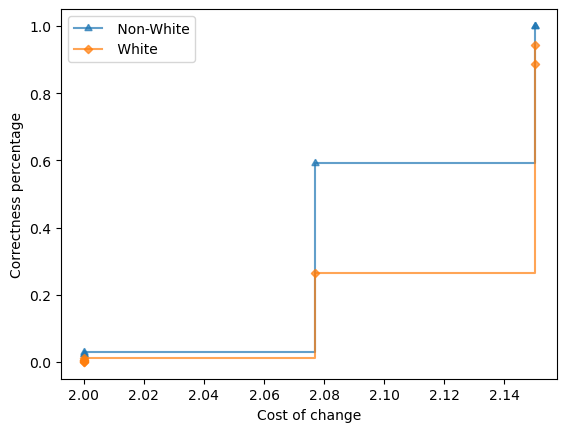

If capital-gain = 0, capital-loss = 0, native-country =  United-States:
	Protected Subgroup ' Non-White', 74.83% covered out of 1748
		Make capital-gain = 3103 with effectiveness 10.43% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 17.14% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 21.42% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 33.63% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 36.14% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 83.10% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 83.10% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 83.10% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 83.10% and counterfactual cost = 0.45.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
	Protected Subg

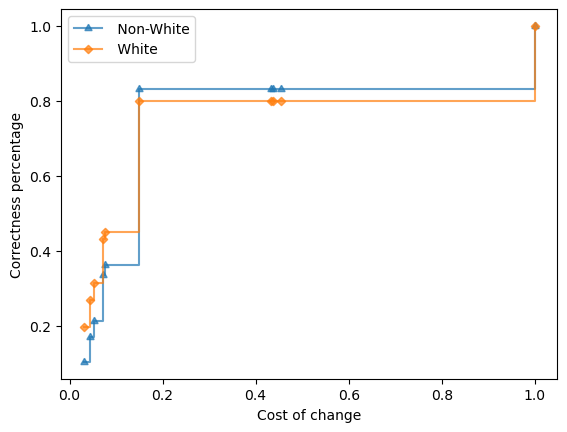

If age = (16.999, 26.0], capital-gain = 0, capital-loss = 0, relationship =  Own-child:
	Protected Subgroup ' Non-White', 10.89% covered out of 1748
		Make age = (26.0, 34.0], relationship =  Married with effectiveness 0.00% and counterfactual cost = 11.0.
		Make age = (34.0, 41.0], relationship =  Married with effectiveness 1.11% and counterfactual cost = 11.0.
		Make age = (34.0, 41.0], capital-gain = 7298, relationship =  Married with effectiveness 57.78% and counterfactual cost = 11.07.
		Make age = (34.0, 41.0], capital-gain = 15024, relationship =  Married with effectiveness 100.00% and counterfactual cost = 11.15.
	Protected Subgroup ' White', 13.24% covered out of 8977
		Make age = (26.0, 34.0], relationship =  Married with effectiveness 0.08% and counterfactual cost = 11.0.
		Make age = (34.0, 41.0], relationship =  Married with effectiveness 0.17% and counterfactual cost = 11.0.
		Make age = (34.0, 41.0], capital-gain = 7298, relationship =  Married with effectiveness 32.38% 

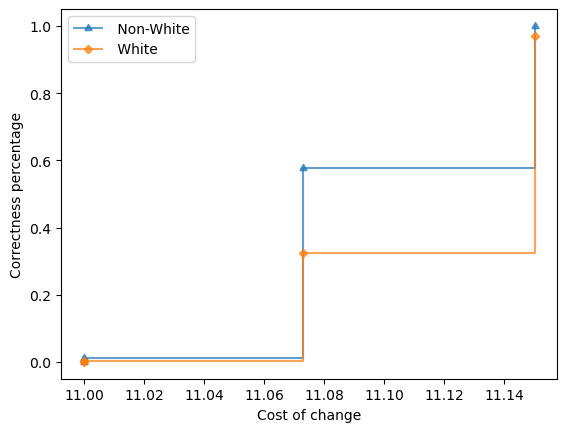

If age = (16.999, 26.0], capital-gain = 0, relationship =  Own-child:
	Protected Subgroup ' Non-White', 11.07% covered out of 1748
		Make age = (26.0, 34.0], relationship =  Married with effectiveness 0.00% and counterfactual cost = 11.0.
		Make age = (34.0, 41.0], relationship =  Married with effectiveness 1.09% and counterfactual cost = 11.0.
		Make age = (34.0, 41.0], capital-gain = 7298, relationship =  Married with effectiveness 57.92% and counterfactual cost = 11.07.
		Make age = (34.0, 41.0], capital-gain = 15024, relationship =  Married with effectiveness 100.00% and counterfactual cost = 11.15.
	Protected Subgroup ' White', 13.57% covered out of 8977
		Make age = (26.0, 34.0], relationship =  Married with effectiveness 0.25% and counterfactual cost = 11.0.
		Make age = (34.0, 41.0], relationship =  Married with effectiveness 0.41% and counterfactual cost = 11.0.
		Make age = (34.0, 41.0], capital-gain = 7298, relationship =  Married with effectiveness 33.17% and counterfactual

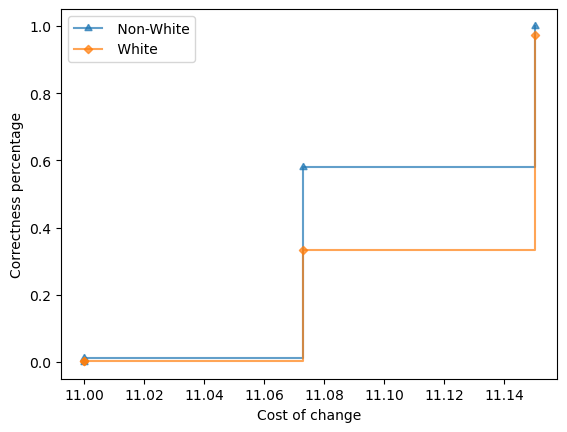

If capital-gain = 0, marital-status =  Never-married, native-country =  United-States, occupation =  Other-service:
	Protected Subgroup ' Non-White', 6.84% covered out of 1748
		Make marital-status =  Married-civ-spouse, occupation =  Transport-moving with effectiveness 0.88% and counterfactual cost = 2.0.
		Make marital-status =  Married-civ-spouse, occupation =  Sales with effectiveness 1.77% and counterfactual cost = 2.0.
		Make marital-status =  Married-civ-spouse, occupation =  Craft-repair with effectiveness 1.77% and counterfactual cost = 2.0.
		Make marital-status =  Married-civ-spouse, occupation =  Adm-clerical with effectiveness 1.77% and counterfactual cost = 2.0.
		Make marital-status =  Married-civ-spouse, occupation =  Protective-serv with effectiveness 1.77% and counterfactual cost = 2.0.
		Make marital-status =  Married-civ-spouse, occupation =  Exec-managerial with effectiveness 3.54% and counterfactual cost = 2.0.
		Make marital-status =  Married-civ-spouse, occupati

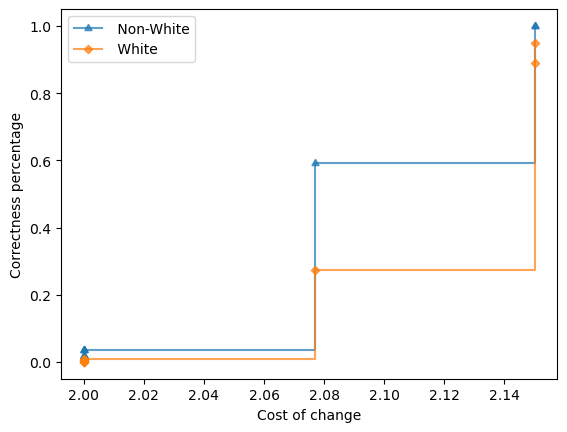

If capital-gain = 0:
	Protected Subgroup ' Non-White', 96.37% covered out of 1748
		Make capital-gain = 3103 with effectiveness 11.36% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 18.08% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 22.91% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 34.97% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 37.79% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 82.74% and counterfactual cost = 0.15.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
	Protected Subgroup ' White', 96.58% covered out of 8977
		Make capital-gain = 3103 with effectiveness 19.37% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 26.46% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 31.08% and counterfactual cost = 0.05.
		Make ca

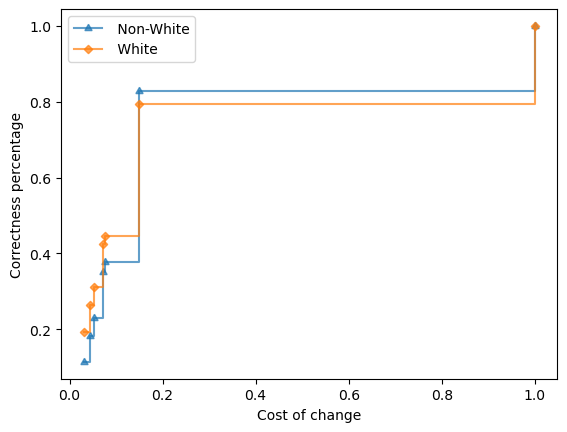

If capital-gain = 0, capital-loss = 0:
	Protected Subgroup ' Non-White', 94.13% covered out of 1748
		Make capital-gain = 3103 with effectiveness 10.80% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 17.48% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 22.30% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 34.38% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 37.08% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 82.46% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 82.46% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 82.46% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 82.46% and counterfactual cost = 0.45.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
	Protected Subgroup ' White', 93.72% covered out

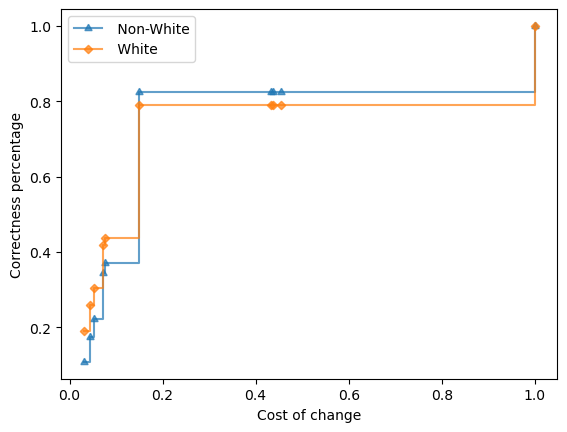

If capital-loss = 0, native-country =  United-States:
	Protected Subgroup ' Non-White', 77.80% covered out of 1748
		Make capital-loss = 1887 with effectiveness 14.31% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 14.46% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 14.93% and counterfactual cost = 0.45.
	Protected Subgroup ' White', 89.71% covered out of 8977
		Make capital-loss = 1887 with effectiveness 22.89% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 23.20% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 24.07% and counterfactual cost = 0.45.
	 Unfairness based on the Kolmogorov-Smirnov test = 3.12.
	Cumulative effectiveness plot for the above recourses:


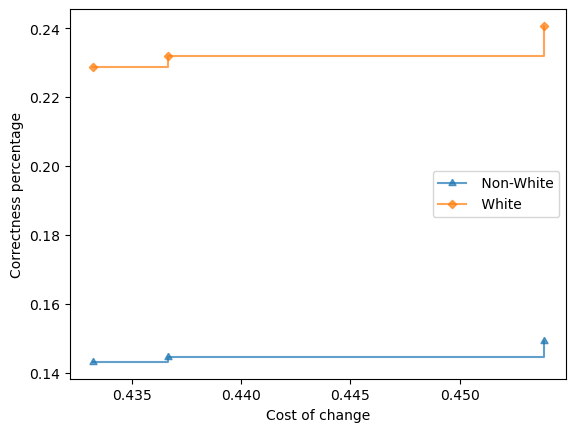

If capital-gain = 0, capital-loss = 0, marital-status =  Never-married, native-country =  United-States, occupation =  Other-service:
	Protected Subgroup ' Non-White', 6.59% covered out of 1748
		Make marital-status =  Married-civ-spouse, occupation =  Sales with effectiveness 0.92% and counterfactual cost = 2.0.
		Make marital-status =  Married-civ-spouse, occupation =  Craft-repair with effectiveness 0.92% and counterfactual cost = 2.0.
		Make marital-status =  Married-civ-spouse, occupation =  Adm-clerical with effectiveness 0.92% and counterfactual cost = 2.0.
		Make marital-status =  Married-civ-spouse, occupation =  Protective-serv with effectiveness 0.92% and counterfactual cost = 2.0.
		Make marital-status =  Married-civ-spouse, occupation =  Exec-managerial with effectiveness 2.75% and counterfactual cost = 2.0.
		Make marital-status =  Married-civ-spouse, occupation =  Prof-specialty with effectiveness 2.75% and counterfactual cost = 2.0.
		Make marital-status =  Married-civ-

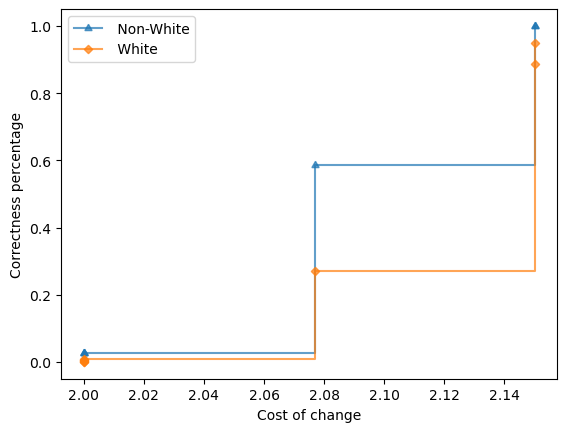

If capital-gain = 0, capital-loss = 0, occupation =  Other-service:
	Protected Subgroup ' Non-White', 18.21% covered out of 1748
		Make occupation =  Craft-repair with effectiveness 1.99% and counterfactual cost = 1.0.
		Make occupation =  Adm-clerical with effectiveness 2.66% and counterfactual cost = 1.0.
		Make occupation =  Sales with effectiveness 3.99% and counterfactual cost = 1.0.
		Make occupation =  Protective-serv with effectiveness 5.98% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with effectiveness 8.31% and counterfactual cost = 1.0.
		Make occupation =  Tech-support with effectiveness 8.64% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with effectiveness 10.30% and counterfactual cost = 1.0.
		Make capital-gain = 7688, occupation =  Prof-specialty with effectiveness 41.53% and counterfactual cost = 1.08.
		Make capital-gain = 15024, occupation =  Prof-specialty with effectiveness 90.03% and counterfactual cost = 1.15.
		Make c

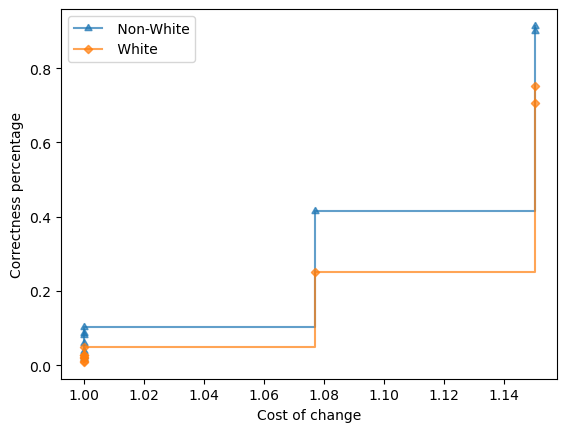

If capital-gain = 0, native-country =  United-States, sex =  Male:
	Protected Subgroup ' Non-White', 36.54% covered out of 1748
		Make capital-gain = 3103 with effectiveness 17.88% and counterfactual cost = 0.03.
		Make capital-gain = 5178 with effectiveness 30.13% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 42.88% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 44.54% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 83.28% and counterfactual cost = 0.15.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
	Protected Subgroup ' White', 56.01% covered out of 8977
		Make capital-gain = 3103 with effectiveness 28.20% and counterfactual cost = 0.03.
		Make capital-gain = 5178 with effectiveness 42.84% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 54.24% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 56

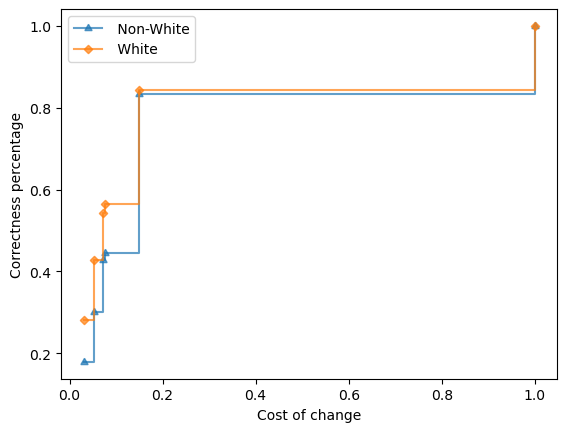

If capital-loss = 0:
	Protected Subgroup ' Non-White', 97.76% covered out of 1748
		Make capital-loss = 1887 with effectiveness 14.79% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 14.91% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 15.28% and counterfactual cost = 0.45.
	Protected Subgroup ' White', 97.14% covered out of 8977
		Make capital-loss = 1887 with effectiveness 22.03% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 22.32% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 23.18% and counterfactual cost = 0.45.
	 Unfairness based on the Kolmogorov-Smirnov test = 2.98.
	Cumulative effectiveness plot for the above recourses:


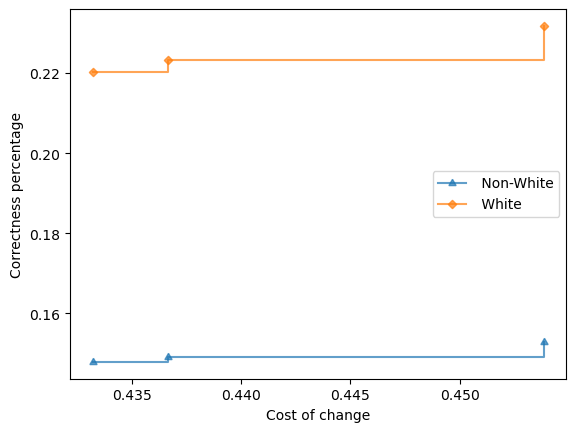

If capital-gain = 0, occupation =  Other-service:
	Protected Subgroup ' Non-White', 18.57% covered out of 1748
		Make occupation =  Transport-moving with effectiveness 0.98% and counterfactual cost = 1.0.
		Make occupation =  Craft-repair with effectiveness 2.28% and counterfactual cost = 1.0.
		Make occupation =  Adm-clerical with effectiveness 2.93% and counterfactual cost = 1.0.
		Make occupation =  Sales with effectiveness 4.23% and counterfactual cost = 1.0.
		Make occupation =  Protective-serv with effectiveness 6.19% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with effectiveness 8.47% and counterfactual cost = 1.0.
		Make occupation =  Tech-support with effectiveness 8.79% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with effectiveness 10.42% and counterfactual cost = 1.0.
		Make capital-gain = 7688, occupation =  Prof-specialty with effectiveness 42.02% and counterfactual cost = 1.08.
		Make capital-gain = 15024, occupation =  Prof-

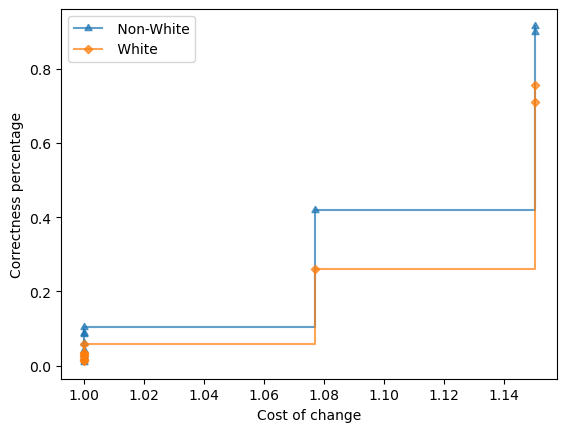

If age = (16.999, 26.0], capital-gain = 0, capital-loss = 0, education-num = 9, hours-per-week = FullTime, marital-status =  Never-married, relationship =  Own-child:
	Protected Subgroup ' Non-White', 2.48% covered out of 1748
		Make age = (34.0, 41.0], education-num = 10, hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 63.41% and counterfactual cost = 33.0.
	Protected Subgroup ' White', 1.73% covered out of 8977
		Make age = (34.0, 41.0], education-num = 10, hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 12.90% and counterfactual cost = 33.0.
	 Unfairness based on the Kolmogorov-Smirnov test = 2.94.
	Cumulative effectiveness plot for the above recourses:


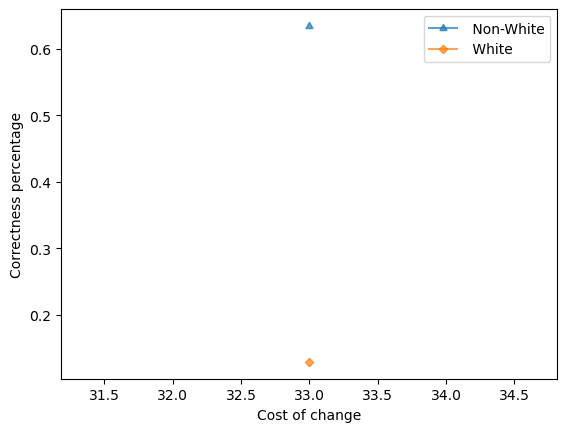

If capital-gain = 0, capital-loss = 0, native-country =  United-States, sex =  Male:
	Protected Subgroup ' Non-White', 35.51% covered out of 1748
		Make capital-gain = 3103 with effectiveness 17.21% and counterfactual cost = 0.03.
		Make capital-gain = 5178 with effectiveness 29.81% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 42.42% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 43.95% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 83.13% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 83.13% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 83.13% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 83.13% and counterfactual cost = 0.45.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
	Protected Subgroup ' White', 54.35% covered out of 8977
		Make capital-gain = 3103 wit

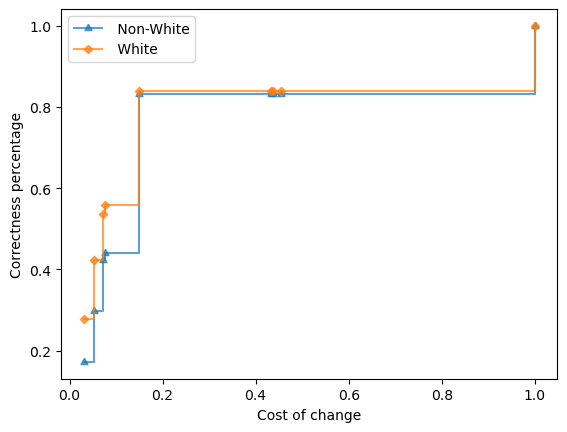

If age = (16.999, 26.0], capital-gain = 0, education-num = 9, hours-per-week = FullTime, marital-status =  Never-married, relationship =  Own-child:
	Protected Subgroup ' Non-White', 2.48% covered out of 1748
		Make age = (34.0, 41.0], education-num = 10, hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 63.41% and counterfactual cost = 33.0.
	Protected Subgroup ' White', 1.74% covered out of 8977
		Make age = (34.0, 41.0], education-num = 10, hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 13.46% and counterfactual cost = 33.0.
	 Unfairness based on the Kolmogorov-Smirnov test = 2.91.
	Cumulative effectiveness plot for the above recourses:


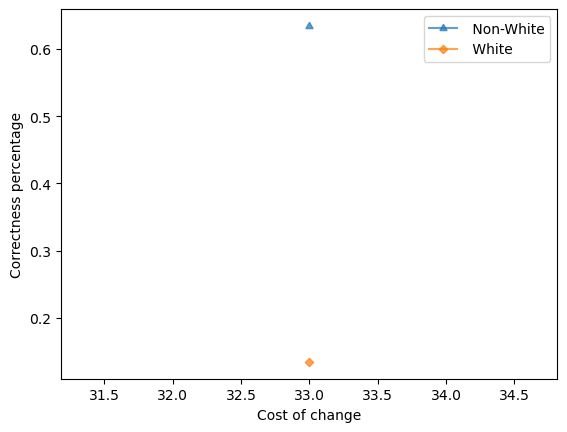

If age = (16.999, 26.0], capital-loss = 0, education-num = 9, hours-per-week = FullTime, marital-status =  Never-married, relationship =  Own-child:
	Protected Subgroup ' Non-White', 2.48% covered out of 1748
		Make age = (34.0, 41.0], hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 39.02% and counterfactual cost = 13.0.
		Make age = (34.0, 41.0], education-num = 10, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 39.02% and counterfactual cost = 32.0.
		Make age = (34.0, 41.0], education-num = 10, hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 63.41% and counterfactual cost = 33.0.
	Protected Subgroup ' White', 1.77% covered out of 8977
		Make age = (34.0, 41.0], hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 5.66% and counterfactual cost = 13.0.
		Make age = (34.0, 41.0], 

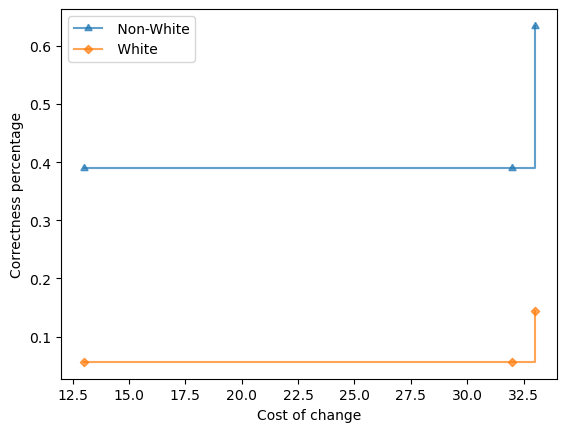

If Workclass =  Private, capital-gain = 0, capital-loss = 0, marital-status =  Never-married, relationship =  Own-child, sex =  Male:
	Protected Subgroup ' Non-White', 7.26% covered out of 1748
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 4.17% and counterfactual cost = 11.0.
		Make capital-gain = 7298, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 61.67% and counterfactual cost = 11.07.
		Make capital-gain = 7688, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 73.33% and counterfactual cost = 11.08.
		Make capital-gain = 15024, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 100.00% and counterfactual cost = 11.15.
		Make capital-loss = 1887, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 100.00% and counterfactual cost = 11.43.
		Make capital-loss = 1902, marital-status =  Married-civ-spouse, relationship = 

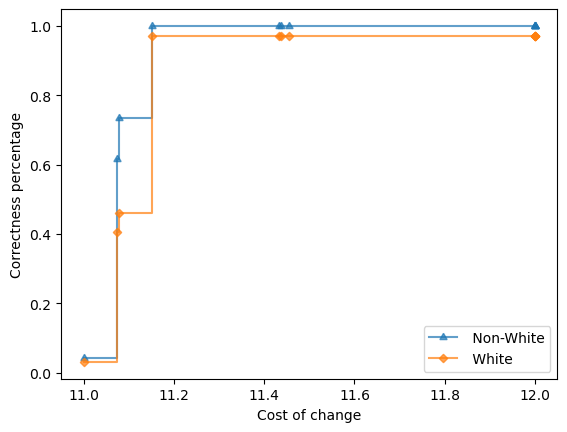

If age = (16.999, 26.0], education-num = 9, hours-per-week = FullTime, marital-status =  Never-married, relationship =  Own-child:
	Protected Subgroup ' Non-White', 2.48% covered out of 1748
		Make age = (34.0, 41.0], hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 39.02% and counterfactual cost = 13.0.
		Make age = (34.0, 41.0], education-num = 10, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 39.02% and counterfactual cost = 32.0.
		Make age = (34.0, 41.0], education-num = 10, hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 63.41% and counterfactual cost = 33.0.
	Protected Subgroup ' White', 1.78% covered out of 8977
		Make age = (34.0, 41.0], hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 6.25% and counterfactual cost = 13.0.
		Make age = (34.0, 41.0], education-num = 10

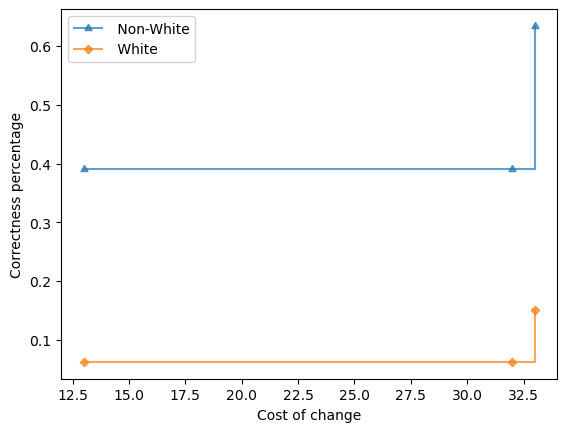

If Workclass =  Private, capital-gain = 0, native-country =  United-States:
	Protected Subgroup ' Non-White', 57.89% covered out of 1748
		Make capital-gain = 7298 with effectiveness 30.09% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 32.71% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 80.67% and counterfactual cost = 0.15.
		Make Workclass =  Local-gov with effectiveness 80.67% and counterfactual cost = 1.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 80.67% and counterfactual cost = 1.0.
		Make Workclass =  State-gov with effectiveness 80.67% and counterfactual cost = 1.0.
		Make Workclass =  Self-emp-inc with effectiveness 80.67% and counterfactual cost = 1.0.
		Make Workclass =  Federal-gov with effectiveness 80.67% and counterfactual cost = 1.0.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
	Protected Subgroup ' White', 68.69% covered out of 8977
		Make capital-ga

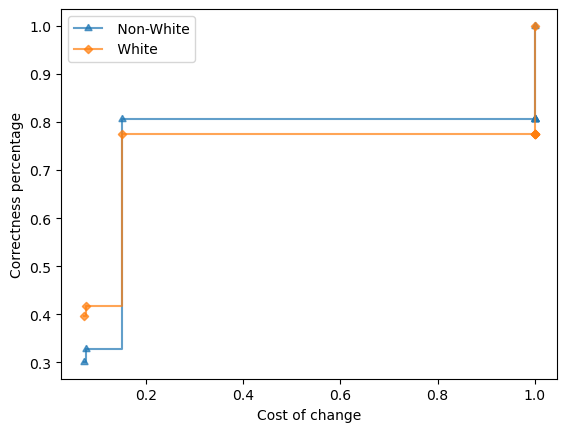

If capital-gain = 0, capital-loss = 0, marital-status =  Never-married, relationship =  Own-child, sex =  Male:
	Protected Subgroup ' Non-White', 8.47% covered out of 1748
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 5.71% and counterfactual cost = 11.0.
		Make capital-gain = 3103, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 24.29% and counterfactual cost = 11.03.
		Make capital-gain = 5178, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 43.57% and counterfactual cost = 11.05.
		Make capital-gain = 7298, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 62.86% and counterfactual cost = 11.07.
		Make capital-gain = 7688, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 72.86% and counterfactual cost = 11.08.
		Make capital-gain = 15024, marital-status =  Married-civ-spouse, relationship =  Married with effectiven

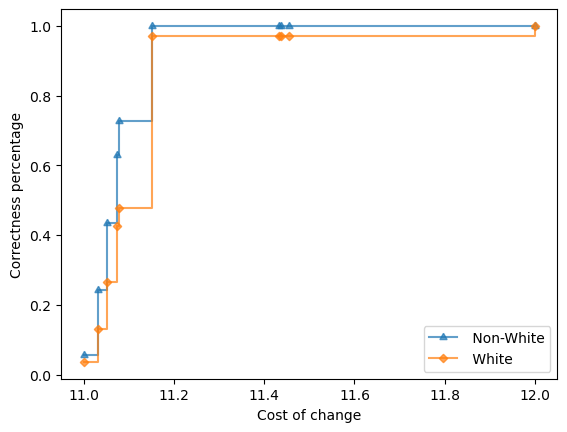

If Workclass =  Private, capital-gain = 0, marital-status =  Never-married, relationship =  Own-child, sex =  Male:
	Protected Subgroup ' Non-White', 7.50% covered out of 1748
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 5.65% and counterfactual cost = 11.0.
		Make capital-gain = 7298, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 62.10% and counterfactual cost = 11.07.
		Make capital-gain = 7688, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 73.39% and counterfactual cost = 11.08.
		Make capital-gain = 15024, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 100.00% and counterfactual cost = 11.15.
		Make Workclass =  Self-emp-not-inc, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 100.00% and counterfactual cost = 12.0.
		Make Workclass =  State-gov, marital-status =  Married-civ-spouse, relationship =  Marri

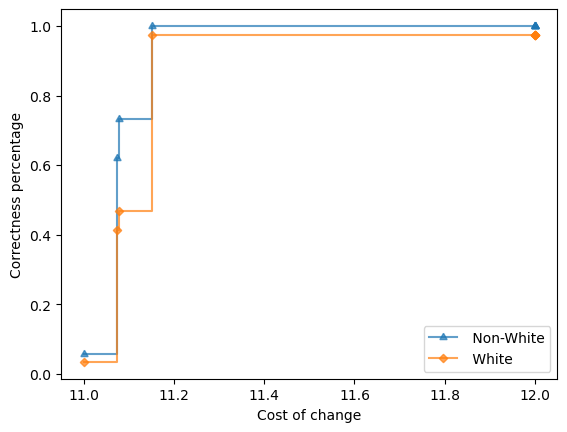

If capital-gain = 0, marital-status =  Never-married, relationship =  Own-child, sex =  Male:
	Protected Subgroup ' Non-White', 8.71% covered out of 1748
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 6.94% and counterfactual cost = 11.0.
		Make capital-gain = 3103, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 25.00% and counterfactual cost = 11.03.
		Make capital-gain = 5178, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 43.75% and counterfactual cost = 11.05.
		Make capital-gain = 7298, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 63.19% and counterfactual cost = 11.07.
		Make capital-gain = 7688, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 72.92% and counterfactual cost = 11.08.
		Make capital-gain = 15024, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 100.00% and co

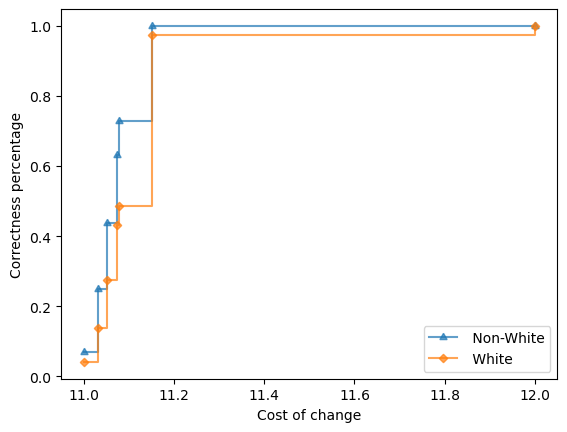

If capital-gain = 0, capital-loss = 0, marital-status =  Never-married, native-country =  United-States, relationship =  Own-child, sex =  Male:
	Protected Subgroup ' Non-White', 7.08% covered out of 1748
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 6.84% and counterfactual cost = 11.0.
		Make capital-gain = 3103, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 26.50% and counterfactual cost = 11.03.
		Make capital-gain = 5178, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 47.01% and counterfactual cost = 11.05.
		Make capital-gain = 7298, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 63.25% and counterfactual cost = 11.07.
		Make capital-gain = 7688, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 75.21% and counterfactual cost = 11.08.
		Make capital-gain = 15024, marital-status =  Married-civ-spouse, relati

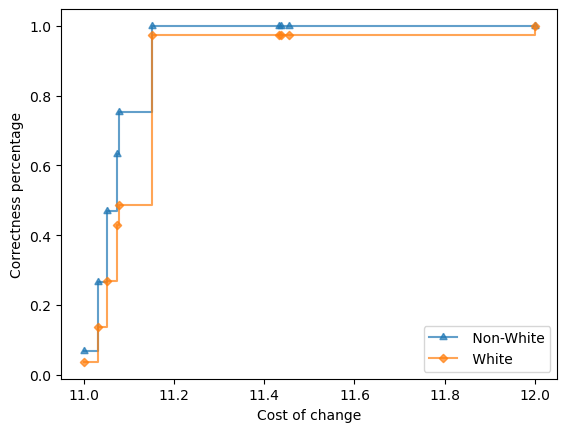

If Workclass =  Private, capital-gain = 0, capital-loss = 0, native-country =  United-States:
	Protected Subgroup ' Non-White', 56.38% covered out of 1748
		Make capital-gain = 7298 with effectiveness 29.40% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 31.87% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 80.36% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 80.36% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 80.36% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 80.36% and counterfactual cost = 0.45.
		Make Workclass =  Local-gov with effectiveness 80.36% and counterfactual cost = 1.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 80.36% and counterfactual cost = 1.0.
		Make Workclass =  State-gov with effectiveness 80.36% and counterfactual cost = 1.0.
		Make Workclass =  Self-emp-inc with effectiveness 80.36% and cou

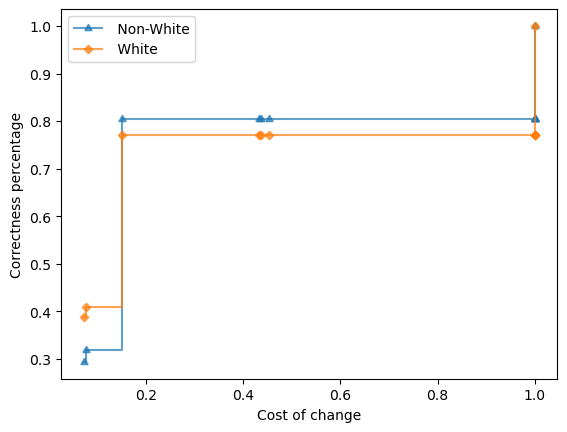

If Workclass =  Private, capital-gain = 0, capital-loss = 0, marital-status =  Never-married, native-country =  United-States, relationship =  Own-child, sex =  Male:
	Protected Subgroup ' Non-White', 5.99% covered out of 1748
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 5.05% and counterfactual cost = 11.0.
		Make capital-gain = 7298, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 61.62% and counterfactual cost = 11.07.
		Make capital-gain = 7688, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 75.76% and counterfactual cost = 11.08.
		Make capital-gain = 15024, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 100.00% and counterfactual cost = 11.15.
		Make capital-loss = 1887, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 100.00% and counterfactual cost = 11.43.
		Make capital-loss = 1902, marital-status =  Ma

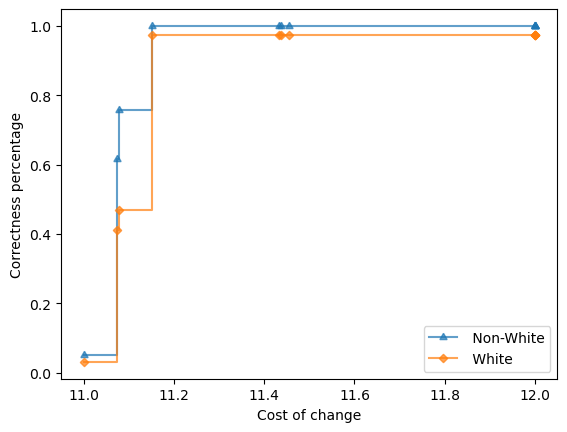

If capital-gain = 0, capital-loss = 0, native-country =  United-States, occupation =  Other-service:
	Protected Subgroup ' Non-White', 13.91% covered out of 1748
		Make occupation =  Craft-repair with effectiveness 1.30% and counterfactual cost = 1.0.
		Make occupation =  Adm-clerical with effectiveness 1.74% and counterfactual cost = 1.0.
		Make occupation =  Sales with effectiveness 3.04% and counterfactual cost = 1.0.
		Make occupation =  Protective-serv with effectiveness 4.35% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with effectiveness 6.96% and counterfactual cost = 1.0.
		Make occupation =  Tech-support with effectiveness 7.39% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with effectiveness 9.13% and counterfactual cost = 1.0.
		Make capital-gain = 7688, occupation =  Prof-specialty with effectiveness 37.39% and counterfactual cost = 1.08.
		Make capital-gain = 15024, occupation =  Prof-specialty with effectiveness 90.00% and coun

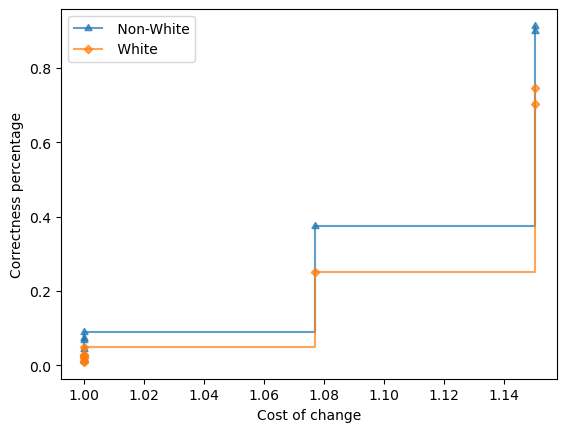

If age = (16.999, 26.0], capital-gain = 0, capital-loss = 0, marital-status =  Never-married:
	Protected Subgroup ' Non-White', 20.39% covered out of 1748
		Make age = (26.0, 34.0], marital-status =  Married-civ-spouse with effectiveness 1.19% and counterfactual cost = 2.0.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse with effectiveness 3.26% and counterfactual cost = 2.0.
		Make age = (34.0, 41.0], capital-gain = 7298, marital-status =  Married-civ-spouse with effectiveness 58.16% and counterfactual cost = 2.07.
		Make age = (34.0, 41.0], capital-gain = 15024, marital-status =  Married-civ-spouse with effectiveness 100.00% and counterfactual cost = 2.15.
	Protected Subgroup ' White', 21.30% covered out of 8977
		Make age = (26.0, 34.0], marital-status =  Married-civ-spouse with effectiveness 0.10% and counterfactual cost = 2.0.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse with effectiveness 1.88% and counterfactual cost = 2.0.
		Make age = (34.0, 

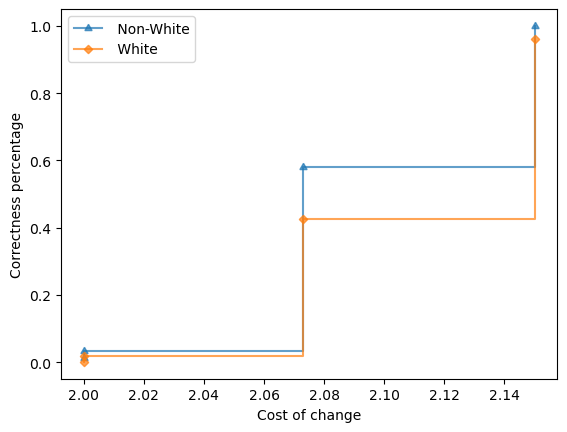

If Workclass =  Private, capital-gain = 0, marital-status =  Never-married, native-country =  United-States, relationship =  Own-child, sex =  Male:
	Protected Subgroup ' Non-White', 6.23% covered out of 1748
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 6.80% and counterfactual cost = 11.0.
		Make capital-gain = 7298, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 62.14% and counterfactual cost = 11.07.
		Make capital-gain = 7688, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 75.73% and counterfactual cost = 11.08.
		Make capital-gain = 15024, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 100.00% and counterfactual cost = 11.15.
		Make Workclass =  Self-emp-not-inc, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 100.00% and counterfactual cost = 12.0.
		Make Workclass =  State-gov, marital-status =  Married-

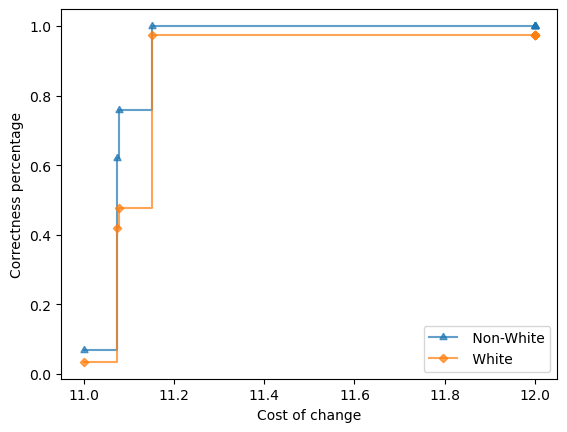

If Workclass =  Private, age = (16.999, 26.0], capital-gain = 0, education-num = 9, hours-per-week = FullTime, marital-status =  Never-married, relationship =  Own-child:
	Protected Subgroup ' Non-White', 2.24% covered out of 1748
		Make age = (34.0, 41.0], education-num = 10, hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 62.16% and counterfactual cost = 33.0.
	Protected Subgroup ' White', 1.54% covered out of 8977
		Make age = (34.0, 41.0], education-num = 10, hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 13.04% and counterfactual cost = 33.0.
	 Unfairness based on the Kolmogorov-Smirnov test = 2.71.
	Cumulative effectiveness plot for the above recourses:


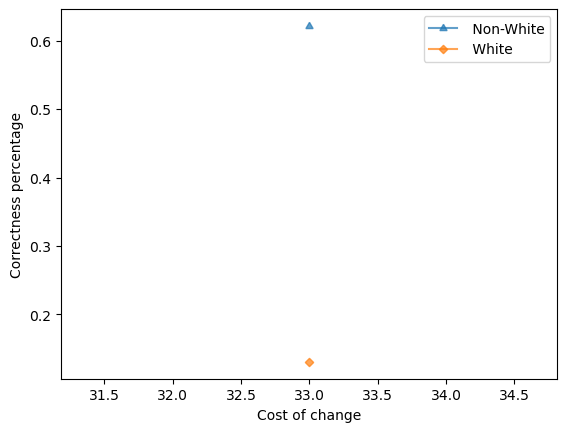

If capital-gain = 0, marital-status =  Never-married, native-country =  United-States, relationship =  Own-child, sex =  Male:
	Protected Subgroup ' Non-White', 7.32% covered out of 1748
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 8.26% and counterfactual cost = 11.0.
		Make capital-gain = 3103, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 27.27% and counterfactual cost = 11.03.
		Make capital-gain = 5178, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 47.11% and counterfactual cost = 11.05.
		Make capital-gain = 7298, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 63.64% and counterfactual cost = 11.07.
		Make capital-gain = 7688, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 75.21% and counterfactual cost = 11.08.
		Make capital-gain = 15024, marital-status =  Married-civ-spouse, relationship =  Married 

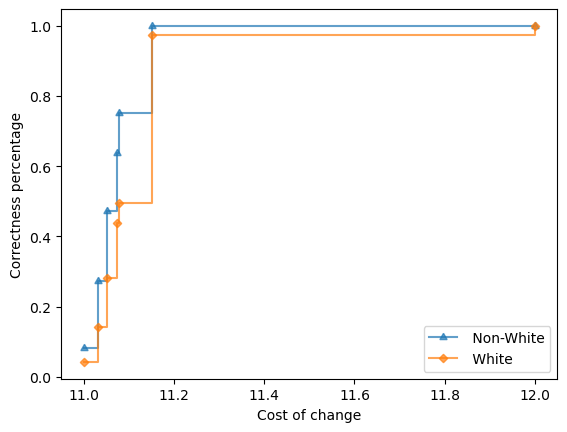

If capital-gain = 0, capital-loss = 0, marital-status =  Never-married:
	Protected Subgroup ' Non-White', 44.46% covered out of 1748
		Make marital-status =  Married-civ-spouse with effectiveness 3.27% and counterfactual cost = 1.0.
		Make capital-gain = 3103, marital-status =  Married-civ-spouse with effectiveness 14.01% and counterfactual cost = 1.03.
		Make capital-gain = 4386, marital-status =  Married-civ-spouse with effectiveness 19.59% and counterfactual cost = 1.04.
		Make capital-gain = 5178, marital-status =  Married-civ-spouse with effectiveness 24.22% and counterfactual cost = 1.05.
		Make capital-gain = 7298, marital-status =  Married-civ-spouse with effectiveness 40.54% and counterfactual cost = 1.07.
		Make capital-gain = 7688, marital-status =  Married-civ-spouse with effectiveness 43.54% and counterfactual cost = 1.08.
		Make capital-gain = 15024, marital-status =  Married-civ-spouse with effectiveness 94.15% and counterfactual cost = 1.15.
		Make capital-loss = 1887, 

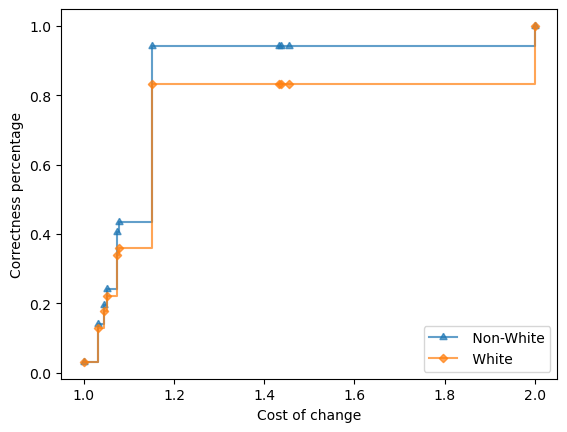

If Workclass =  Private, capital-gain = 0, capital-loss = 0, marital-status =  Never-married:
	Protected Subgroup ' Non-White', 36.12% covered out of 1748
		Make marital-status =  Married-civ-spouse with effectiveness 2.51% and counterfactual cost = 1.0.
		Make capital-gain = 7298, marital-status =  Married-civ-spouse with effectiveness 37.19% and counterfactual cost = 1.07.
		Make capital-gain = 7688, marital-status =  Married-civ-spouse with effectiveness 40.03% and counterfactual cost = 1.08.
		Make capital-gain = 15024, marital-status =  Married-civ-spouse with effectiveness 93.97% and counterfactual cost = 1.15.
		Make capital-loss = 1887, marital-status =  Married-civ-spouse with effectiveness 93.97% and counterfactual cost = 1.43.
		Make capital-loss = 1902, marital-status =  Married-civ-spouse with effectiveness 93.97% and counterfactual cost = 1.44.
		Make capital-loss = 1977, marital-status =  Married-civ-spouse with effectiveness 93.97% and counterfactual cost = 1.45.
		Make

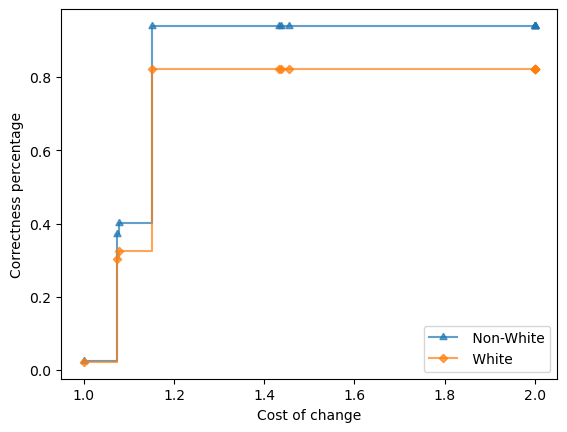

If capital-gain = 0, native-country =  United-States, occupation =  Other-service:
	Protected Subgroup ' Non-White', 14.28% covered out of 1748
		Make occupation =  Transport-moving with effectiveness 0.85% and counterfactual cost = 1.0.
		Make occupation =  Craft-repair with effectiveness 1.69% and counterfactual cost = 1.0.
		Make occupation =  Adm-clerical with effectiveness 2.12% and counterfactual cost = 1.0.
		Make occupation =  Sales with effectiveness 3.39% and counterfactual cost = 1.0.
		Make occupation =  Protective-serv with effectiveness 4.66% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with effectiveness 7.20% and counterfactual cost = 1.0.
		Make occupation =  Tech-support with effectiveness 7.63% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with effectiveness 9.32% and counterfactual cost = 1.0.
		Make capital-gain = 7688, occupation =  Prof-specialty with effectiveness 38.14% and counterfactual cost = 1.08.
		Make capital-g

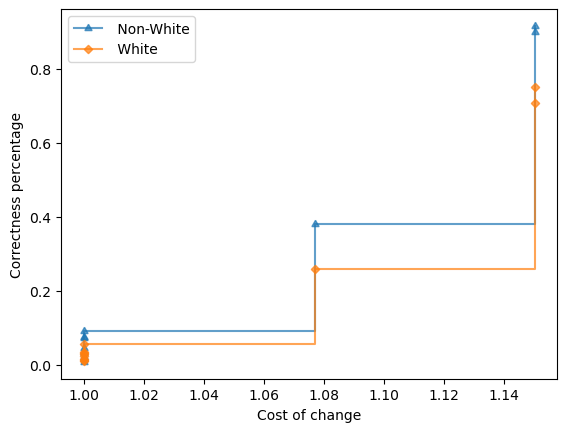

If capital-gain = 0, marital-status =  Never-married:
	Protected Subgroup ' Non-White', 45.80% covered out of 1748
		Make marital-status =  Married-civ-spouse with effectiveness 4.23% and counterfactual cost = 1.0.
		Make capital-gain = 3103, marital-status =  Married-civ-spouse with effectiveness 15.32% and counterfactual cost = 1.03.
		Make capital-gain = 4386, marital-status =  Married-civ-spouse with effectiveness 20.87% and counterfactual cost = 1.04.
		Make capital-gain = 5178, marital-status =  Married-civ-spouse with effectiveness 25.36% and counterfactual cost = 1.05.
		Make capital-gain = 7298, marital-status =  Married-civ-spouse with effectiveness 42.01% and counterfactual cost = 1.07.
		Make capital-gain = 7688, marital-status =  Married-civ-spouse with effectiveness 44.91% and counterfactual cost = 1.08.
		Make capital-gain = 15024, marital-status =  Married-civ-spouse with effectiveness 94.19% and counterfactual cost = 1.15.
		Make capital-gain = 99999, marital-status = 

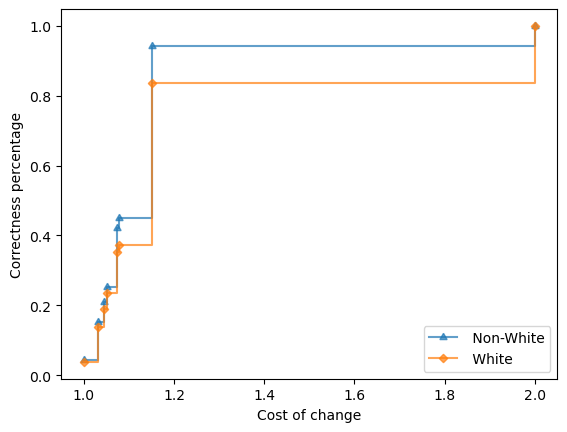

If Workclass =  Private, capital-gain = 0, marital-status =  Never-married:
	Protected Subgroup ' Non-White', 37.14% covered out of 1748
		Make marital-status =  Married-civ-spouse with effectiveness 3.26% and counterfactual cost = 1.0.
		Make capital-gain = 7298, marital-status =  Married-civ-spouse with effectiveness 38.60% and counterfactual cost = 1.07.
		Make capital-gain = 7688, marital-status =  Married-civ-spouse with effectiveness 41.37% and counterfactual cost = 1.08.
		Make capital-gain = 15024, marital-status =  Married-civ-spouse with effectiveness 93.97% and counterfactual cost = 1.15.
		Make Workclass =  Self-emp-not-inc, marital-status =  Married-civ-spouse with effectiveness 93.97% and counterfactual cost = 2.0.
		Make Workclass =  State-gov, marital-status =  Married-civ-spouse with effectiveness 93.97% and counterfactual cost = 2.0.
		Make Workclass =  Local-gov, marital-status =  Married-civ-spouse with effectiveness 93.97% and counterfactual cost = 2.0.
		Make Work

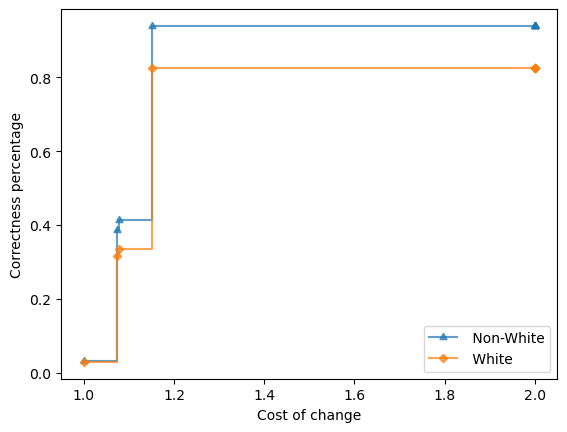

If age = (16.999, 26.0], capital-gain = 0, marital-status =  Never-married:
	Protected Subgroup ' Non-White', 20.69% covered out of 1748
		Make age = (26.0, 34.0], marital-status =  Married-civ-spouse with effectiveness 1.17% and counterfactual cost = 2.0.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse with effectiveness 3.22% and counterfactual cost = 2.0.
		Make age = (34.0, 41.0], capital-gain = 7298, marital-status =  Married-civ-spouse with effectiveness 58.48% and counterfactual cost = 2.07.
		Make age = (34.0, 41.0], capital-gain = 15024, marital-status =  Married-civ-spouse with effectiveness 100.00% and counterfactual cost = 2.15.
	Protected Subgroup ' White', 21.87% covered out of 8977
		Make age = (26.0, 34.0], marital-status =  Married-civ-spouse with effectiveness 0.51% and counterfactual cost = 2.0.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse with effectiveness 2.39% and counterfactual cost = 2.0.
		Make age = (34.0, 41.0], capital-gai

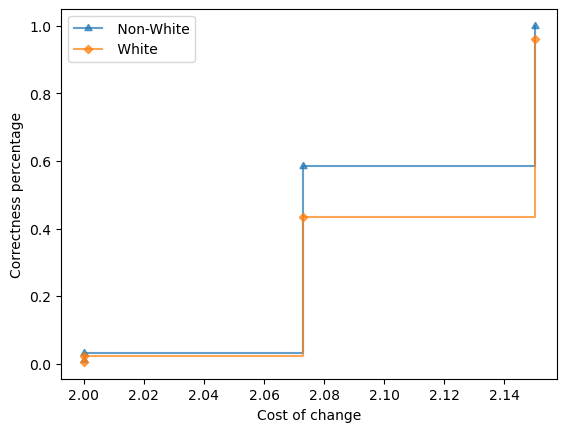

If Workclass =  Private, capital-gain = 0, occupation =  Other-service:
	Protected Subgroup ' Non-White', 15.31% covered out of 1748
		Make occupation =  Transport-moving with effectiveness 0.79% and counterfactual cost = 1.0.
		Make occupation =  Craft-repair with effectiveness 2.37% and counterfactual cost = 1.0.
		Make occupation =  Adm-clerical with effectiveness 3.16% and counterfactual cost = 1.0.
		Make occupation =  Sales with effectiveness 4.74% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with effectiveness 9.09% and counterfactual cost = 1.0.
		Make occupation =  Tech-support with effectiveness 9.09% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with effectiveness 9.49% and counterfactual cost = 1.0.
		Make capital-gain = 15024, occupation =  Exec-managerial with effectiveness 90.91% and counterfactual cost = 1.15.
		Make Workclass =  Self-emp-not-inc, occupation =  Sales with effectiveness 90.91% and counterfactual cost = 2.0.
		M

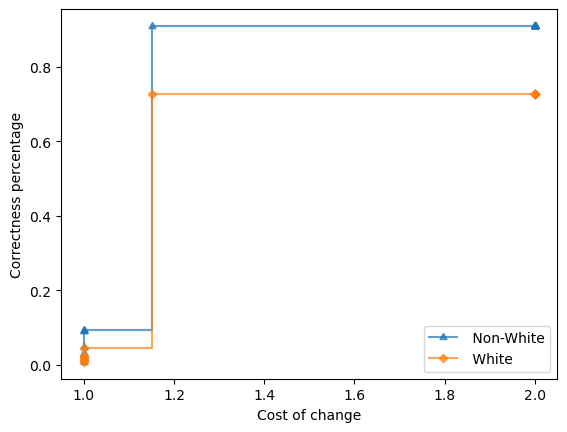

If Workclass =  Private, capital-gain = 0, capital-loss = 0, occupation =  Other-service:
	Protected Subgroup ' Non-White', 15.00% covered out of 1748
		Make occupation =  Craft-repair with effectiveness 2.02% and counterfactual cost = 1.0.
		Make occupation =  Adm-clerical with effectiveness 2.82% and counterfactual cost = 1.0.
		Make occupation =  Sales with effectiveness 4.44% and counterfactual cost = 1.0.
		Make occupation =  Prof-specialty with effectiveness 8.87% and counterfactual cost = 1.0.
		Make occupation =  Tech-support with effectiveness 8.87% and counterfactual cost = 1.0.
		Make occupation =  Exec-managerial with effectiveness 9.27% and counterfactual cost = 1.0.
		Make capital-gain = 15024, occupation =  Exec-managerial with effectiveness 90.73% and counterfactual cost = 1.15.
		Make Workclass =  Self-emp-not-inc, occupation =  Prof-specialty with effectiveness 90.73% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc, occupation =  Exec-managerial wi

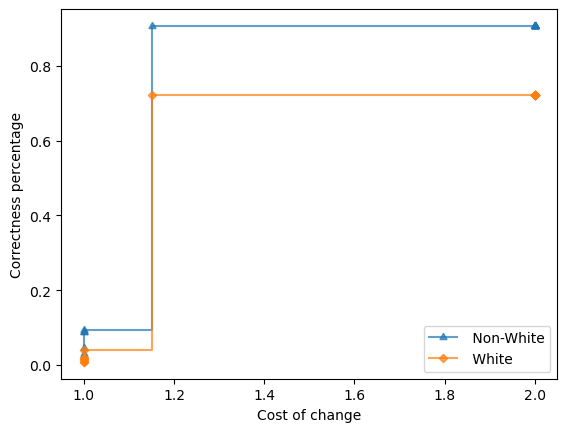

If Workclass =  Private, age = (16.999, 26.0], education-num = 9, hours-per-week = FullTime, marital-status =  Never-married, relationship =  Own-child:
	Protected Subgroup ' Non-White', 2.24% covered out of 1748
		Make age = (34.0, 41.0], hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 37.84% and counterfactual cost = 13.0.
		Make age = (34.0, 41.0], education-num = 10, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 37.84% and counterfactual cost = 32.0.
		Make age = (34.0, 41.0], education-num = 10, hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 62.16% and counterfactual cost = 33.0.
	Protected Subgroup ' White', 1.58% covered out of 8977
		Make age = (34.0, 41.0], hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 5.63% and counterfactual cost = 13.0.
		Make age = (34.0, 41.

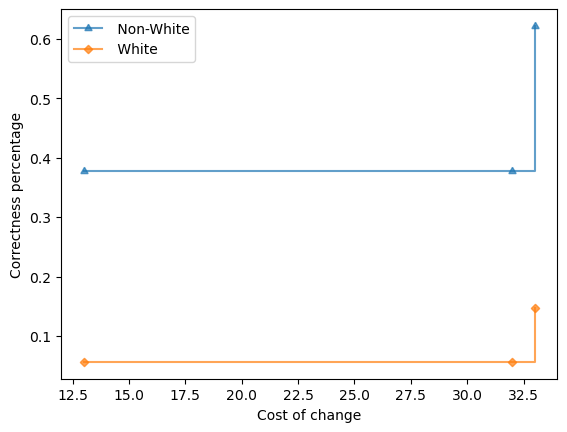

In [ ]:
affected_pop_sizes = {sg: ((X_test["race"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["race"].unique()}

top_rules,unfairness = facts.select_rules_subset_KStest(
    rules_with_cumulative,
    affected_pop_sizes,
    top_count=50
)

print_recourse_report_KStest_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    unfairness = unfairness,
    show_then_costs=True,
    show_cumulative_plots=True
)